In [1]:
from __future__ import print_function
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torch.nn.init as init
import argparse
import numpy as np
from torch.autograd import Variable
import torch.utils.data as data
from data import (VOCroot, VOC_300, VOC_512,
    AnnotationTransform, VOCDetection, VOCSegmentation,
    detection_collate, preproc, GISSDetection)
from layers.modules import MultiBoxLoss
from layers.functions import PriorBox
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
import pandas as pd
from matplotlib import patches


def __clean_slashes_df(df_annots):

    df_annots.filename = df_annots.filename.str.replace("\\", "/")

    return df_annots


def get_center(x):
    x['x'] = x.xmax - x.xmin
    x['y'] = x.ymax - x.ymin
    return x


def show_bbs(image, y_image, i=0):
    
    plt.rcParams['figure.figsize'] = (16, 12)

    color = 'r'
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.add_patch(patches.Rectangle((y_image['xmin'],
                                    y_image['ymin']),
                                   y_image['x'],
                                   y_image['y'], facecolor='none',
                                   edgecolor=color, lw=2))

    return

In [3]:
plt.rcParams['figure.figsize'] = (12, 9)

In [4]:
version = 'RFB_vgg'
size = '512'
dataset_ = 'VOC'
device = 'cuda:0'

basenet = './weights/vgg16_reducedfc.pth'
jaccard_threshold = 0.5
batch_size = 6
img_dim = int(size)

num_workers = 4
cuda = True
ngpu = 1

resume_net = None  # './weights/RFB_vgg_VOC_epoches_190.pth'
resume_epoch = 0

lr = 5e-3
momentum = 0.9
max_epoch = 500
weight_decay = 1e-5
gamma = 0.1

log_iters = True
save_folder = './weights/'

In [5]:
if dataset_ == 'VOC':
    train_sets = [('2007', 'trainval'), ('2012', 'trainval')]
    cfg = (VOC_300, VOC_512)[size == '512']
else:
    train_sets = [('2014', 'train'), ('2014', 'valminusminival')]
    cfg = (COCO_300, COCO_512)[size == '512']

if version == 'RFB_vgg':
    from models.RFB_Net_vgg import build_net
elif version == 'RFB_E_vgg':
    from models.RFB_Net_E_vgg import build_net
elif version == 'RFB_mobile':
    from models.RFB_Net_mobile import build_net
    cfg = COCO_mobile_300
else:
    print('Unkown version!')

rgb_means = ((104, 117, 123), (103.94, 116.78, 123.68))[
    version == 'RFB_mobile']
p = (0.6, 0.2)[version == 'RFB_mobile']

batch_size = batch_size
weight_decay = 0.0005
gamma = 0.1
momentum = 0.9

print('dim: {}'.format(img_dim))

dim: 512


In [6]:
BASEDIR = '/home/w/projects/pw-giss/data/data/giss_images/original/'
LABELS_DIR = '/home/w/projects/pw-giss/data/models/labels/csv/labels_21_05_deg0/'
TRAIN_LABELS = LABELS_DIR + 'train_labels_21_05_deg0.csv'
VAL_LABELS = LABELS_DIR + 'val_labels_21_05_deg0.csv'
TEST_LABELS = LABELS_DIR + 'test_labels_21_05_deg0.csv'

VOCroot = '../data/data/VOCdevkit/'

In [7]:
use_giss = True


if use_giss:
    dataset = GISSDetection(BASEDIR, TRAIN_LABELS, preproc(
                img_dim, rgb_means, p))
    num_classes = 8
else:
    dataset = VOCDetection(VOCroot, train_sets, preproc(
            img_dim, rgb_means, p), AnnotationTransform())
    num_classes = 21

batch_iterator = iter(data.DataLoader(dataset, batch_size,
                    shuffle=True, num_workers=num_workers, collate_fn=detection_collate))

In [8]:
net = build_net('train', img_dim, num_classes)
print(net)

if resume_net == None:
    base_weights = torch.load(basenet)
    print('Loading base network...')
    net.base.load_state_dict(base_weights)

    def xavier(param):
        init.xavier_uniform(param)

    def weights_init(m):
        for key in m.state_dict():
            if key.split('.')[-1] == 'weight':
                if 'conv' in key:
                    init.kaiming_normal_(m.state_dict()[key], mode='fan_out')
                if 'bn' in key:
                    m.state_dict()[key][...] = 1
            elif key.split('.')[-1] == 'bias':
                m.state_dict()[key][...] = 0

    print('Initializing weights...')
# initialize newly added layers' weights with kaiming_normal method
    net.extras.apply(weights_init)
    net.loc.apply(weights_init)
    net.conf.apply(weights_init)
    net.Norm.apply(weights_init)
    if version == 'RFB_E_vgg':
        net.reduce.apply(weights_init)
        net.up_reduce.apply(weights_init)

else:
    # load resume network
    print('Loading resume network...')
    state_dict = torch.load(resume_net)
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        head = k[:7]
        if head == 'module.':
            name = k[7:]  # remove `module.`
        else:
            name = k
        new_state_dict[name] = v
    net.load_state_dict(new_state_dict)
    

net.to(device)
cudnn.benchmark = True


optimizer = optim.SGD(net.parameters(), lr=lr,
                  momentum=momentum, weight_decay=weight_decay)

criterion = MultiBoxLoss(num_classes, 0.5, True, 0, True, 3, 0.5, False, device=device)
priorbox = PriorBox(cfg)
with torch.no_grad():
    priors = priorbox.forward()
if cuda:
    priors = priors.to(device)

RFBNet(
  (base): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(2

In [9]:
epoch_size = len(dataset) // batch_size
max_iter = max_epoch * epoch_size

stepvalues_VOC = (150 * epoch_size, 200 * epoch_size, 250 * epoch_size)
stepvalues_COCO = (90 * epoch_size, 120 * epoch_size, 140 * epoch_size)
stepvalues = (stepvalues_VOC, stepvalues_COCO)[dataset_ == 'COCO']
print('Training', version, 'on', dataset.name)
step_index = 0
epoch = 0 + resume_epoch
lr = 1e-5

loc_loss = 0  # epoch
conf_loss = 0

if resume_epoch > 0:
    start_iter = resume_epoch * epoch_size
else:
    start_iter = 0


def adjust_learning_rate(optimizer, gamma, epoch, step_index, iteration, epoch_size, lr=1e-5):
    """Sets the learning rate
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    if epoch < 6:
        lr = 1e-6 + (lr - 1e-6) * iteration / (epoch_size * 5)
    else:
        lr = lr * (gamma ** (step_index))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


for iteration in range(start_iter, max_iter):
    if iteration % epoch_size == 0:
        # create batch iterator
        batch_iterator = iter(data.DataLoader(dataset, batch_size,
                                              shuffle=True, num_workers=num_workers, collate_fn=detection_collate))
        loc_loss = 0
        conf_loss = 0
        if (epoch % 10 == 0 and epoch > 0) or (epoch % 5 == 0 and epoch > 200):
            torch.save(net.state_dict(), save_folder + version + '_' + dataset_ + '_epoches_' +
                       repr(epoch) + '.pth')
        epoch += 1

    load_t0 = time.time()
    if iteration in stepvalues:
        step_index += 1
    lr = adjust_learning_rate(
        optimizer, gamma, epoch, step_index, iteration, epoch_size)

    # load train data
    images, targets = next(batch_iterator)

    if cuda:
        images = Variable(images.to(device))
        targets = [Variable(anno.to(device)) for anno in targets]
    else:
        images = Variable(images)
        targets = [Variable(anno) for anno in targets]
    # forward
    t0 = time.time()
    out = net(images)
    # backprop
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, priors, targets)
    loss = loss_l + loss_c
    loss.backward()
    optimizer.step()
    t1 = time.time()
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
    load_t1 = time.time()
    if iteration % 10 == 0:
        print('Epoch:' + repr(epoch) + ' || epochiter: ' + repr(iteration % epoch_size) + '/' + repr(epoch_size)
              + '|| Totel iter ' +
              repr(iteration) + ' || L: %.4f C: %.4f||' % (
            loss_l.item(), loss_c.item()) +
            'Batch time: %.4f sec. ||' % (load_t1 - load_t0) + 'LR: %.8f' % (lr))

Training RFB_vgg on train


/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch:1 || epochiter: 0/24|| Totel iter 0 || L: 4.8073 C: 15.0298||Batch time: 9.2570 sec. ||LR: 0.00000100
Epoch:1 || epochiter: 10/24|| Totel iter 10 || L: 4.3880 C: 14.0874||Batch time: 0.5472 sec. ||LR: 0.00000175
Epoch:1 || epochiter: 20/24|| Totel iter 20 || L: 7.2468 C: 14.8722||Batch time: 0.5448 sec. ||LR: 0.00000250
Epoch:2 || epochiter: 6/24|| Totel iter 30 || L: 5.0434 C: 13.2392||Batch time: 0.5689 sec. ||LR: 0.00000325
Epoch:2 || epochiter: 16/24|| Totel iter 40 || L: 3.8878 C: 12.8552||Batch time: 0.5469 sec. ||LR: 0.00000400
Epoch:3 || epochiter: 2/24|| Totel iter 50 || L: 4.6108 C: 11.8749||Batch time: 0.5414 sec. ||LR: 0.00000475
Epoch:3 || epochiter: 12/24|| Totel iter 60 || L: 4.1768 C: 10.9387||Batch time: 0.5472 sec. ||LR: 0.00000550
Epoch:3 || epochiter: 22/24|| Totel iter 70 || L: 3.8291 C: 10.3510||Batch time: 0.5588 sec. ||LR: 0.00000625
Epoch:4 || epochiter: 8/24|| Totel iter 80 || L: 3.2373 C: 9.9659||Batch time: 0.5712 sec. ||LR: 0.00000700
Epoch:4 || epoch

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda119e8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:7 || epochiter: 6/24|| Totel iter 150 || L: 4.2323 C: 9.0891||Batch time: 0.5441 sec. ||LR: 0.00001000
Epoch:7 || epochiter: 16/24|| Totel iter 160 || L: 4.2284 C: 8.5754||Batch time: 0.5548 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f72e8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:8 || epochiter: 2/24|| Totel iter 170 || L: 4.5870 C: 8.4905||Batch time: 0.5641 sec. ||LR: 0.00001000
Epoch:8 || epochiter: 12/24|| Totel iter 180 || L: 3.9692 C: 8.9789||Batch time: 0.5702 sec. ||LR: 0.00001000
Epoch:8 || epochiter: 22/24|| Totel iter 190 || L: 3.1536 C: 8.0533||Batch time: 0.5621 sec. ||LR: 0.00001000
Epoch:9 || epochiter: 8/24|| Totel iter 200 || L: 2.8615 C: 7.6169||Batch time: 0.5675 sec. ||LR: 0.00001000
Epoch:9 || epochiter: 18/24|| Totel iter 210 || L: 3.3277 C: 7.6891||Batch time: 0.5596 sec. ||LR: 0.00001000
Epoch:10 || epochiter: 4/24|| Totel iter 220 || L: 3.0885 C: 7.6185||Batch time: 0.5687 sec. ||LR: 0.00001000
Epoch:10 || epochiter: 14/24|| Totel iter 230 || L: 3.5073 C: 7.4449||Batch time: 0.5682 sec. ||LR: 0.00001000
Epoch:11 || epochiter: 0/24|| Totel iter 240 || L: 3.0472 C: 7.6942||Batch time: 1.9443 sec. ||LR: 0.00001000
Epoch:11 || epochiter: 10/24|| Totel iter 250 || L: 4.8143 C: 7.9748||Batch time: 0.5655 sec. ||LR: 0.00001000
Epoch:11 |

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3588>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:18 || epochiter: 2/24|| Totel iter 410 || L: 2.3678 C: 5.9014||Batch time: 0.5659 sec. ||LR: 0.00001000
Epoch:18 || epochiter: 12/24|| Totel iter 420 || L: 2.3161 C: 5.7978||Batch time: 0.5656 sec. ||LR: 0.00001000
Epoch:18 || epochiter: 22/24|| Totel iter 430 || L: 2.4840 C: 5.9817||Batch time: 0.5652 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4a90>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:19 || epochiter: 8/24|| Totel iter 440 || L: 2.8097 C: 5.8950||Batch time: 0.5768 sec. ||LR: 0.00001000
Epoch:19 || epochiter: 18/24|| Totel iter 450 || L: 2.2202 C: 6.0055||Batch time: 0.5519 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059833b38>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:20 || epochiter: 4/24|| Totel iter 460 || L: 3.1343 C: 7.3698||Batch time: 0.5722 sec. ||LR: 0.00001000
Epoch:20 || epochiter: 14/24|| Totel iter 470 || L: 16.8948 C: 9.4229||Batch time: 0.5538 sec. ||LR: 0.00001000
Epoch:21 || epochiter: 0/24|| Totel iter 480 || L: 3.7482 C: 6.7967||Batch time: 2.0938 sec. ||LR: 0.00001000
Epoch:21 || epochiter: 10/24|| Totel iter 490 || L: 4.8584 C: 7.6010||Batch time: 0.5623 sec. ||LR: 0.00001000
Epoch:21 || epochiter: 20/24|| Totel iter 500 || L: 2.2144 C: 5.5299||Batch time: 0.5575 sec. ||LR: 0.00001000
Epoch:22 || epochiter: 6/24|| Totel iter 510 || L: 3.2283 C: 6.2741||Batch time: 0.5534 sec. ||LR: 0.00001000
Epoch:22 || epochiter: 16/24|| Totel iter 520 || L: 2.7445 C: 6.1769||Batch time: 0.5668 sec. ||LR: 0.00001000
Epoch:23 || epochiter: 2/24|| Totel iter 530 || L: 4.4899 C: 6.4838||Batch time: 0.5526 sec. ||LR: 0.00001000
Epoch:23 || epochiter: 12/24|| Totel iter 540 || L: 6.0750 C: 7.0370||Batch time: 0.6190 sec. ||LR: 0.00001000
Epoc

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895ef0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:24 || epochiter: 8/24|| Totel iter 560 || L: 3.0015 C: 5.4629||Batch time: 0.5688 sec. ||LR: 0.00001000
Epoch:24 || epochiter: 18/24|| Totel iter 570 || L: 2.3555 C: 5.2770||Batch time: 0.5641 sec. ||LR: 0.00001000
Epoch:25 || epochiter: 4/24|| Totel iter 580 || L: 2.6522 C: 5.8943||Batch time: 0.5645 sec. ||LR: 0.00001000
Epoch:25 || epochiter: 14/24|| Totel iter 590 || L: 4.3476 C: 6.2301||Batch time: 0.5620 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891e10>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:26 || epochiter: 0/24|| Totel iter 600 || L: 2.2180 C: 5.8737||Batch time: 2.2273 sec. ||LR: 0.00001000
Epoch:26 || epochiter: 10/24|| Totel iter 610 || L: 2.2125 C: 4.9970||Batch time: 0.5543 sec. ||LR: 0.00001000
Epoch:26 || epochiter: 20/24|| Totel iter 620 || L: 4.2162 C: 5.5956||Batch time: 0.5678 sec. ||LR: 0.00001000
Epoch:27 || epochiter: 6/24|| Totel iter 630 || L: 3.9505 C: 6.1759||Batch time: 0.5515 sec. ||LR: 0.00001000
Epoch:27 || epochiter: 16/24|| Totel iter 640 || L: 1.8327 C: 4.9595||Batch time: 0.5634 sec. ||LR: 0.00001000
Epoch:28 || epochiter: 2/24|| Totel iter 650 || L: 2.5302 C: 5.3537||Batch time: 0.5665 sec. ||LR: 0.00001000
Epoch:28 || epochiter: 12/24|| Totel iter 660 || L: 2.0508 C: 4.9669||Batch time: 0.5667 sec. ||LR: 0.00001000
Epoch:28 || epochiter: 22/24|| Totel iter 670 || L: 2.3380 C: 5.6202||Batch time: 0.5581 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895f60>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:29 || epochiter: 8/24|| Totel iter 680 || L: 2.1266 C: 5.1941||Batch time: 0.5792 sec. ||LR: 0.00001000
Epoch:29 || epochiter: 18/24|| Totel iter 690 || L: 6.4209 C: 6.5678||Batch time: 0.5564 sec. ||LR: 0.00001000
Epoch:30 || epochiter: 4/24|| Totel iter 700 || L: 1.9583 C: 4.9410||Batch time: 0.5738 sec. ||LR: 0.00001000
Epoch:30 || epochiter: 14/24|| Totel iter 710 || L: 7.2196 C: 6.5237||Batch time: 0.5593 sec. ||LR: 0.00001000
Epoch:31 || epochiter: 0/24|| Totel iter 720 || L: 12.2914 C: 8.1740||Batch time: 2.1917 sec. ||LR: 0.00001000
Epoch:31 || epochiter: 10/24|| Totel iter 730 || L: 2.1775 C: 4.9101||Batch time: 0.5535 sec. ||LR: 0.00001000
Epoch:31 || epochiter: 20/24|| Totel iter 740 || L: 1.8842 C: 4.9987||Batch time: 0.5681 sec. ||LR: 0.00001000
Epoch:32 || epochiter: 6/24|| Totel iter 750 || L: 2.4006 C: 4.8550||Batch time: 0.5602 sec. ||LR: 0.00001000
Epoch:32 || epochiter: 16/24|| Totel iter 760 || L: 3.5829 C: 5.1071||Batch time: 0.5558 sec. ||LR: 0.00001000
Epoc

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598335c0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:39 || epochiter: 8/24|| Totel iter 920 || L: 2.4321 C: 4.5883||Batch time: 0.5698 sec. ||LR: 0.00001000
Epoch:39 || epochiter: 18/24|| Totel iter 930 || L: 2.3874 C: 4.7878||Batch time: 0.5642 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5051864160>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:40 || epochiter: 4/24|| Totel iter 940 || L: 2.2281 C: 4.5127||Batch time: 0.5625 sec. ||LR: 0.00001000
Epoch:40 || epochiter: 14/24|| Totel iter 950 || L: 1.7836 C: 4.0733||Batch time: 0.5483 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598987b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:41 || epochiter: 0/24|| Totel iter 960 || L: 2.2765 C: 4.4091||Batch time: 2.1244 sec. ||LR: 0.00001000
Epoch:41 || epochiter: 10/24|| Totel iter 970 || L: 2.3197 C: 4.5321||Batch time: 0.5549 sec. ||LR: 0.00001000
Epoch:41 || epochiter: 20/24|| Totel iter 980 || L: 1.7879 C: 4.5269||Batch time: 0.5555 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898550>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:42 || epochiter: 6/24|| Totel iter 990 || L: 3.4796 C: 5.3233||Batch time: 0.5626 sec. ||LR: 0.00001000
Epoch:42 || epochiter: 16/24|| Totel iter 1000 || L: 2.5196 C: 5.1273||Batch time: 0.5536 sec. ||LR: 0.00001000
Epoch:43 || epochiter: 2/24|| Totel iter 1010 || L: 1.6072 C: 4.4662||Batch time: 0.5585 sec. ||LR: 0.00001000
Epoch:43 || epochiter: 12/24|| Totel iter 1020 || L: 1.7009 C: 4.5957||Batch time: 0.5529 sec. ||LR: 0.00001000
Epoch:43 || epochiter: 22/24|| Totel iter 1030 || L: 1.8009 C: 3.9679||Batch time: 0.5680 sec. ||LR: 0.00001000
Epoch:44 || epochiter: 8/24|| Totel iter 1040 || L: 1.4295 C: 4.0577||Batch time: 0.5566 sec. ||LR: 0.00001000
Epoch:44 || epochiter: 18/24|| Totel iter 1050 || L: 3.2090 C: 5.0867||Batch time: 0.5557 sec. ||LR: 0.00001000
Epoch:45 || epochiter: 4/24|| Totel iter 1060 || L: 3.1352 C: 4.7982||Batch time: 0.5643 sec. ||LR: 0.00001000
Epoch:45 || epochiter: 14/24|| Totel iter 1070 || L: 1.6613 C: 3.7037||Batch time: 0.5612 sec. ||LR: 0.000010

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4470>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:47 || epochiter: 6/24|| Totel iter 1110 || L: 1.5760 C: 3.4300||Batch time: 0.5541 sec. ||LR: 0.00001000
Epoch:47 || epochiter: 16/24|| Totel iter 1120 || L: 2.5526 C: 5.0899||Batch time: 0.5563 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898a20>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:48 || epochiter: 2/24|| Totel iter 1130 || L: 1.9865 C: 3.9869||Batch time: 0.5631 sec. ||LR: 0.00001000
Epoch:48 || epochiter: 12/24|| Totel iter 1140 || L: 1.6595 C: 3.6805||Batch time: 0.5663 sec. ||LR: 0.00001000
Epoch:48 || epochiter: 22/24|| Totel iter 1150 || L: 2.1797 C: 4.2093||Batch time: 0.5640 sec. ||LR: 0.00001000
Epoch:49 || epochiter: 8/24|| Totel iter 1160 || L: 2.1435 C: 4.2507||Batch time: 0.5612 sec. ||LR: 0.00001000
Epoch:49 || epochiter: 18/24|| Totel iter 1170 || L: 1.9072 C: 4.0121||Batch time: 0.5500 sec. ||LR: 0.00001000
Epoch:50 || epochiter: 4/24|| Totel iter 1180 || L: 2.3121 C: 4.3544||Batch time: 0.5619 sec. ||LR: 0.00001000
Epoch:50 || epochiter: 14/24|| Totel iter 1190 || L: 2.5034 C: 4.3276||Batch time: 0.5553 sec. ||LR: 0.00001000
Epoch:51 || epochiter: 0/24|| Totel iter 1200 || L: 1.6232 C: 3.7206||Batch time: 2.1071 sec. ||LR: 0.00001000
Epoch:51 || epochiter: 10/24|| Totel iter 1210 || L: 1.6404 C: 3.5566||Batch time: 0.5424 sec. ||LR: 0.00001

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11a20>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:53 || epochiter: 2/24|| Totel iter 1250 || L: 1.9495 C: 3.9553||Batch time: 0.5595 sec. ||LR: 0.00001000
Epoch:53 || epochiter: 12/24|| Totel iter 1260 || L: 1.9938 C: 3.9427||Batch time: 0.5689 sec. ||LR: 0.00001000
Epoch:53 || epochiter: 22/24|| Totel iter 1270 || L: 1.4745 C: 4.0106||Batch time: 0.5669 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4da0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:54 || epochiter: 8/24|| Totel iter 1280 || L: 1.8781 C: 4.1960||Batch time: 0.5611 sec. ||LR: 0.00001000
Epoch:54 || epochiter: 18/24|| Totel iter 1290 || L: 1.4543 C: 3.5995||Batch time: 0.5585 sec. ||LR: 0.00001000
Epoch:55 || epochiter: 4/24|| Totel iter 1300 || L: 1.6007 C: 3.6501||Batch time: 0.5648 sec. ||LR: 0.00001000
Epoch:55 || epochiter: 14/24|| Totel iter 1310 || L: 2.1245 C: 3.6876||Batch time: 0.5655 sec. ||LR: 0.00001000
Epoch:56 || epochiter: 0/24|| Totel iter 1320 || L: 1.4153 C: 3.5099||Batch time: 2.2550 sec. ||LR: 0.00001000
Epoch:56 || epochiter: 10/24|| Totel iter 1330 || L: 1.9007 C: 3.9258||Batch time: 0.5675 sec. ||LR: 0.00001000
Epoch:56 || epochiter: 20/24|| Totel iter 1340 || L: 1.8081 C: 3.4454||Batch time: 0.5535 sec. ||LR: 0.00001000
Epoch:57 || epochiter: 6/24|| Totel iter 1350 || L: 3.6802 C: 4.2925||Batch time: 0.5526 sec. ||LR: 0.00001000
Epoch:57 || epochiter: 16/24|| Totel iter 1360 || L: 3.5606 C: 4.6336||Batch time: 0.5494 sec. ||LR: 0.00001

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11d68>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:58 || epochiter: 2/24|| Totel iter 1370 || L: 1.6836 C: 3.7223||Batch time: 0.5604 sec. ||LR: 0.00001000
Epoch:58 || epochiter: 12/24|| Totel iter 1380 || L: 1.9881 C: 3.9394||Batch time: 0.5754 sec. ||LR: 0.00001000
Epoch:58 || epochiter: 22/24|| Totel iter 1390 || L: 2.5795 C: 3.9587||Batch time: 0.5571 sec. ||LR: 0.00001000
Epoch:59 || epochiter: 8/24|| Totel iter 1400 || L: 1.4794 C: 3.3192||Batch time: 0.5603 sec. ||LR: 0.00001000
Epoch:59 || epochiter: 18/24|| Totel iter 1410 || L: 2.4408 C: 3.9090||Batch time: 0.5547 sec. ||LR: 0.00001000
Epoch:60 || epochiter: 4/24|| Totel iter 1420 || L: 2.1116 C: 3.8467||Batch time: 0.5642 sec. ||LR: 0.00001000
Epoch:60 || epochiter: 14/24|| Totel iter 1430 || L: 1.1572 C: 3.6293||Batch time: 0.5477 sec. ||LR: 0.00001000
Epoch:61 || epochiter: 0/24|| Totel iter 1440 || L: 1.1928 C: 3.3990||Batch time: 2.0190 sec. ||LR: 0.00001000
Epoch:61 || epochiter: 10/24|| Totel iter 1450 || L: 1.7837 C: 3.7247||Batch time: 0.5567 sec. ||LR: 0.00001

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895588>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:66 || epochiter: 0/24|| Totel iter 1560 || L: 4.2138 C: 4.4429||Batch time: 2.2120 sec. ||LR: 0.00001000
Epoch:66 || epochiter: 10/24|| Totel iter 1570 || L: 1.6429 C: 3.6923||Batch time: 0.5539 sec. ||LR: 0.00001000
Epoch:66 || epochiter: 20/24|| Totel iter 1580 || L: 3.3889 C: 4.0050||Batch time: 0.5575 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898c88>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:67 || epochiter: 6/24|| Totel iter 1590 || L: 2.1993 C: 4.0627||Batch time: 0.5558 sec. ||LR: 0.00001000
Epoch:67 || epochiter: 16/24|| Totel iter 1600 || L: 1.5657 C: 3.4663||Batch time: 0.5583 sec. ||LR: 0.00001000
Epoch:68 || epochiter: 2/24|| Totel iter 1610 || L: 4.2465 C: 4.7019||Batch time: 0.5614 sec. ||LR: 0.00001000
Epoch:68 || epochiter: 12/24|| Totel iter 1620 || L: 4.3914 C: 4.6042||Batch time: 0.5643 sec. ||LR: 0.00001000
Epoch:68 || epochiter: 22/24|| Totel iter 1630 || L: 2.2464 C: 4.2322||Batch time: 0.5585 sec. ||LR: 0.00001000
Epoch:69 || epochiter: 8/24|| Totel iter 1640 || L: 1.5418 C: 3.8467||Batch time: 0.5568 sec. ||LR: 0.00001000
Epoch:69 || epochiter: 18/24|| Totel iter 1650 || L: 3.1285 C: 4.2502||Batch time: 0.5581 sec. ||LR: 0.00001000
Epoch:70 || epochiter: 4/24|| Totel iter 1660 || L: 1.6393 C: 3.1840||Batch time: 0.5560 sec. ||LR: 0.00001000
Epoch:70 || epochiter: 14/24|| Totel iter 1670 || L: 1.5144 C: 3.2755||Batch time: 0.5629 sec. ||LR: 0.00001

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895be0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:72 || epochiter: 6/24|| Totel iter 1710 || L: 2.3113 C: 3.6448||Batch time: 0.5555 sec. ||LR: 0.00001000
Epoch:72 || epochiter: 16/24|| Totel iter 1720 || L: 3.3768 C: 4.3183||Batch time: 0.5566 sec. ||LR: 0.00001000
Epoch:73 || epochiter: 2/24|| Totel iter 1730 || L: 2.3412 C: 3.3640||Batch time: 0.5598 sec. ||LR: 0.00001000
Epoch:73 || epochiter: 12/24|| Totel iter 1740 || L: 2.5977 C: 3.3410||Batch time: 0.5520 sec. ||LR: 0.00001000
Epoch:73 || epochiter: 22/24|| Totel iter 1750 || L: 2.0903 C: 3.4032||Batch time: 0.5601 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda810b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:74 || epochiter: 8/24|| Totel iter 1760 || L: 2.6394 C: 3.5893||Batch time: 0.5745 sec. ||LR: 0.00001000
Epoch:74 || epochiter: 18/24|| Totel iter 1770 || L: 1.6316 C: 3.3128||Batch time: 0.5604 sec. ||LR: 0.00001000
Epoch:75 || epochiter: 4/24|| Totel iter 1780 || L: 1.8837 C: 3.5402||Batch time: 0.5598 sec. ||LR: 0.00001000
Epoch:75 || epochiter: 14/24|| Totel iter 1790 || L: 2.0027 C: 3.3456||Batch time: 0.5440 sec. ||LR: 0.00001000
Epoch:76 || epochiter: 0/24|| Totel iter 1800 || L: 2.0226 C: 3.3963||Batch time: 2.2654 sec. ||LR: 0.00001000
Epoch:76 || epochiter: 10/24|| Totel iter 1810 || L: 1.4311 C: 3.0283||Batch time: 0.5539 sec. ||LR: 0.00001000
Epoch:76 || epochiter: 20/24|| Totel iter 1820 || L: 1.7208 C: 3.3077||Batch time: 0.5595 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830160>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:77 || epochiter: 6/24|| Totel iter 1830 || L: 2.4921 C: 3.9122||Batch time: 0.5612 sec. ||LR: 0.00001000
Epoch:77 || epochiter: 16/24|| Totel iter 1840 || L: 1.5191 C: 3.1418||Batch time: 0.5588 sec. ||LR: 0.00001000
Epoch:78 || epochiter: 2/24|| Totel iter 1850 || L: 1.2824 C: 3.0651||Batch time: 0.5717 sec. ||LR: 0.00001000
Epoch:78 || epochiter: 12/24|| Totel iter 1860 || L: 3.0734 C: 5.1434||Batch time: 0.5486 sec. ||LR: 0.00001000
Epoch:78 || epochiter: 22/24|| Totel iter 1870 || L: 3.7563 C: 4.5700||Batch time: 0.5526 sec. ||LR: 0.00001000
Epoch:79 || epochiter: 8/24|| Totel iter 1880 || L: 3.1606 C: 3.6674||Batch time: 0.5590 sec. ||LR: 0.00001000
Epoch:79 || epochiter: 18/24|| Totel iter 1890 || L: 1.7799 C: 3.4028||Batch time: 0.5616 sec. ||LR: 0.00001000
Epoch:80 || epochiter: 4/24|| Totel iter 1900 || L: 0.9656 C: 2.8174||Batch time: 0.5575 sec. ||LR: 0.00001000
Epoch:80 || epochiter: 14/24|| Totel iter 1910 || L: 1.8951 C: 3.4785||Batch time: 0.5496 sec. ||LR: 0.00001

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059833c88>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:86 || epochiter: 0/24|| Totel iter 2040 || L: 1.1032 C: 2.6100||Batch time: 2.2046 sec. ||LR: 0.00001000
Epoch:86 || epochiter: 10/24|| Totel iter 2050 || L: 1.2352 C: 2.8736||Batch time: 0.5551 sec. ||LR: 0.00001000
Epoch:86 || epochiter: 20/24|| Totel iter 2060 || L: 1.3106 C: 3.1910||Batch time: 0.5617 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f77b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:87 || epochiter: 6/24|| Totel iter 2070 || L: 1.5870 C: 3.0297||Batch time: 0.5549 sec. ||LR: 0.00001000
Epoch:87 || epochiter: 16/24|| Totel iter 2080 || L: 2.1537 C: 3.2564||Batch time: 0.5583 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598308d0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:88 || epochiter: 2/24|| Totel iter 2090 || L: 1.1122 C: 2.5919||Batch time: 0.5675 sec. ||LR: 0.00001000
Epoch:88 || epochiter: 12/24|| Totel iter 2100 || L: 1.0158 C: 3.0600||Batch time: 0.5841 sec. ||LR: 0.00001000
Epoch:88 || epochiter: 22/24|| Totel iter 2110 || L: 1.8862 C: 3.3301||Batch time: 0.5576 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598337b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:89 || epochiter: 8/24|| Totel iter 2120 || L: 0.9041 C: 2.9330||Batch time: 0.5605 sec. ||LR: 0.00001000
Epoch:89 || epochiter: 18/24|| Totel iter 2130 || L: 1.3130 C: 2.8746||Batch time: 0.5555 sec. ||LR: 0.00001000
Epoch:90 || epochiter: 4/24|| Totel iter 2140 || L: 0.9164 C: 2.7024||Batch time: 0.5692 sec. ||LR: 0.00001000
Epoch:90 || epochiter: 14/24|| Totel iter 2150 || L: 1.6179 C: 3.2286||Batch time: 0.5644 sec. ||LR: 0.00001000
Epoch:91 || epochiter: 0/24|| Totel iter 2160 || L: 2.5586 C: 3.9832||Batch time: 2.1951 sec. ||LR: 0.00001000
Epoch:91 || epochiter: 10/24|| Totel iter 2170 || L: 0.8886 C: 2.6274||Batch time: 0.5598 sec. ||LR: 0.00001000
Epoch:91 || epochiter: 20/24|| Totel iter 2180 || L: 1.8324 C: 3.6313||Batch time: 0.5527 sec. ||LR: 0.00001000
Epoch:92 || epochiter: 6/24|| Totel iter 2190 || L: 1.9068 C: 3.1527||Batch time: 0.5633 sec. ||LR: 0.00001000
Epoch:92 || epochiter: 16/24|| Totel iter 2200 || L: 3.8656 C: 4.0984||Batch time: 0.5557 sec. ||LR: 0.00001

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059837128>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:96 || epochiter: 0/24|| Totel iter 2280 || L: 0.9846 C: 2.7754||Batch time: 2.1566 sec. ||LR: 0.00001000
Epoch:96 || epochiter: 10/24|| Totel iter 2290 || L: 1.3193 C: 3.1401||Batch time: 0.5565 sec. ||LR: 0.00001000
Epoch:96 || epochiter: 20/24|| Totel iter 2300 || L: 1.2179 C: 2.9971||Batch time: 0.5628 sec. ||LR: 0.00001000
Epoch:97 || epochiter: 6/24|| Totel iter 2310 || L: 1.4187 C: 2.9595||Batch time: 0.5615 sec. ||LR: 0.00001000
Epoch:97 || epochiter: 16/24|| Totel iter 2320 || L: 1.1548 C: 3.1282||Batch time: 0.5866 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4668>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:98 || epochiter: 2/24|| Totel iter 2330 || L: 1.5097 C: 3.3899||Batch time: 0.5590 sec. ||LR: 0.00001000
Epoch:98 || epochiter: 12/24|| Totel iter 2340 || L: 1.0756 C: 2.4687||Batch time: 0.5621 sec. ||LR: 0.00001000
Epoch:98 || epochiter: 22/24|| Totel iter 2350 || L: 1.4861 C: 2.8909||Batch time: 0.5554 sec. ||LR: 0.00001000
Epoch:99 || epochiter: 8/24|| Totel iter 2360 || L: 2.0665 C: 3.9102||Batch time: 0.5629 sec. ||LR: 0.00001000
Epoch:99 || epochiter: 18/24|| Totel iter 2370 || L: 1.0768 C: 2.8707||Batch time: 0.5550 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891f28>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:100 || epochiter: 4/24|| Totel iter 2380 || L: 1.1250 C: 2.4443||Batch time: 0.5617 sec. ||LR: 0.00001000
Epoch:100 || epochiter: 14/24|| Totel iter 2390 || L: 1.5912 C: 3.3533||Batch time: 0.5586 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a48d0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:101 || epochiter: 0/24|| Totel iter 2400 || L: 0.7895 C: 2.2965||Batch time: 2.0178 sec. ||LR: 0.00001000
Epoch:101 || epochiter: 10/24|| Totel iter 2410 || L: 0.8098 C: 2.6615||Batch time: 0.5549 sec. ||LR: 0.00001000
Epoch:101 || epochiter: 20/24|| Totel iter 2420 || L: 1.7604 C: 3.4150||Batch time: 0.5675 sec. ||LR: 0.00001000
Epoch:102 || epochiter: 6/24|| Totel iter 2430 || L: 1.8896 C: 2.8925||Batch time: 0.5527 sec. ||LR: 0.00001000
Epoch:102 || epochiter: 16/24|| Totel iter 2440 || L: 1.9212 C: 3.4512||Batch time: 0.5589 sec. ||LR: 0.00001000
Epoch:103 || epochiter: 2/24|| Totel iter 2450 || L: 1.2134 C: 3.1444||Batch time: 0.5516 sec. ||LR: 0.00001000
Epoch:103 || epochiter: 12/24|| Totel iter 2460 || L: 2.1348 C: 3.2522||Batch time: 0.5719 sec. ||LR: 0.00001000
Epoch:103 || epochiter: 22/24|| Totel iter 2470 || L: 1.5387 C: 3.3029||Batch time: 0.5606 sec. ||LR: 0.00001000
Epoch:104 || epochiter: 8/24|| Totel iter 2480 || L: 2.4113 C: 3.6574||Batch time: 0.5649 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11f28>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:106 || epochiter: 0/24|| Totel iter 2520 || L: 1.7784 C: 3.2764||Batch time: 2.1786 sec. ||LR: 0.00001000
Epoch:106 || epochiter: 10/24|| Totel iter 2530 || L: 0.9540 C: 2.7627||Batch time: 0.5579 sec. ||LR: 0.00001000
Epoch:106 || epochiter: 20/24|| Totel iter 2540 || L: 0.9654 C: 2.3716||Batch time: 0.5555 sec. ||LR: 0.00001000
Epoch:107 || epochiter: 6/24|| Totel iter 2550 || L: 1.0287 C: 2.7890||Batch time: 0.5520 sec. ||LR: 0.00001000
Epoch:107 || epochiter: 16/24|| Totel iter 2560 || L: 1.2328 C: 3.6326||Batch time: 0.5475 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598372e8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:108 || epochiter: 2/24|| Totel iter 2570 || L: 1.2389 C: 3.1869||Batch time: 0.5568 sec. ||LR: 0.00001000
Epoch:108 || epochiter: 12/24|| Totel iter 2580 || L: 2.4077 C: 3.5623||Batch time: 0.5548 sec. ||LR: 0.00001000
Epoch:108 || epochiter: 22/24|| Totel iter 2590 || L: 0.9325 C: 2.2795||Batch time: 0.5582 sec. ||LR: 0.00001000
Epoch:109 || epochiter: 8/24|| Totel iter 2600 || L: 1.0994 C: 2.5662||Batch time: 0.5613 sec. ||LR: 0.00001000
Epoch:109 || epochiter: 18/24|| Totel iter 2610 || L: 1.1931 C: 2.3495||Batch time: 0.5518 sec. ||LR: 0.00001000
Epoch:110 || epochiter: 4/24|| Totel iter 2620 || L: 1.3293 C: 3.1075||Batch time: 0.5594 sec. ||LR: 0.00001000
Epoch:110 || epochiter: 14/24|| Totel iter 2630 || L: 1.5824 C: 2.8099||Batch time: 0.5607 sec. ||LR: 0.00001000
Epoch:111 || epochiter: 0/24|| Totel iter 2640 || L: 2.1317 C: 3.3351||Batch time: 2.1161 sec. ||LR: 0.00001000
Epoch:111 || epochiter: 10/24|| Totel iter 2650 || L: 1.0892 C: 2.3389||Batch time: 0.5541 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830a90>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:112 || epochiter: 6/24|| Totel iter 2670 || L: 1.1712 C: 2.9916||Batch time: 0.5593 sec. ||LR: 0.00001000
Epoch:112 || epochiter: 16/24|| Totel iter 2680 || L: 1.4047 C: 3.0742||Batch time: 0.5592 sec. ||LR: 0.00001000
Epoch:113 || epochiter: 2/24|| Totel iter 2690 || L: 1.1618 C: 2.9135||Batch time: 0.5595 sec. ||LR: 0.00001000
Epoch:113 || epochiter: 12/24|| Totel iter 2700 || L: 1.3481 C: 2.5735||Batch time: 0.5576 sec. ||LR: 0.00001000
Epoch:113 || epochiter: 22/24|| Totel iter 2710 || L: 1.2829 C: 2.9672||Batch time: 0.5552 sec. ||LR: 0.00001000
Epoch:114 || epochiter: 8/24|| Totel iter 2720 || L: 1.1283 C: 2.5168||Batch time: 0.5775 sec. ||LR: 0.00001000
Epoch:114 || epochiter: 18/24|| Totel iter 2730 || L: 1.4172 C: 2.6889||Batch time: 0.5590 sec. ||LR: 0.00001000
Epoch:115 || epochiter: 4/24|| Totel iter 2740 || L: 1.1503 C: 2.2961||Batch time: 0.5704 sec. ||LR: 0.00001000
Epoch:115 || epochiter: 14/24|| Totel iter 2750 || L: 1.0914 C: 2.5687||Batch time: 0.5523 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059842550>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:122 || epochiter: 6/24|| Totel iter 2910 || L: 1.5204 C: 2.8894||Batch time: 0.5497 sec. ||LR: 0.00001000
Epoch:122 || epochiter: 16/24|| Totel iter 2920 || L: 0.9877 C: 2.6948||Batch time: 0.5617 sec. ||LR: 0.00001000
Epoch:123 || epochiter: 2/24|| Totel iter 2930 || L: 1.5366 C: 2.9312||Batch time: 0.5617 sec. ||LR: 0.00001000
Epoch:123 || epochiter: 12/24|| Totel iter 2940 || L: 1.4806 C: 2.9822||Batch time: 0.5725 sec. ||LR: 0.00001000
Epoch:123 || epochiter: 22/24|| Totel iter 2950 || L: 1.0235 C: 3.0177||Batch time: 0.5579 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a0ba8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:124 || epochiter: 8/24|| Totel iter 2960 || L: 1.4342 C: 3.0610||Batch time: 0.5706 sec. ||LR: 0.00001000
Epoch:124 || epochiter: 18/24|| Totel iter 2970 || L: 1.1788 C: 2.7540||Batch time: 0.5561 sec. ||LR: 0.00001000
Epoch:125 || epochiter: 4/24|| Totel iter 2980 || L: 0.9371 C: 2.1177||Batch time: 0.5560 sec. ||LR: 0.00001000
Epoch:125 || epochiter: 14/24|| Totel iter 2990 || L: 0.6399 C: 2.2265||Batch time: 0.5626 sec. ||LR: 0.00001000
Epoch:126 || epochiter: 0/24|| Totel iter 3000 || L: 2.8562 C: 3.5142||Batch time: 2.4020 sec. ||LR: 0.00001000
Epoch:126 || epochiter: 10/24|| Totel iter 3010 || L: 1.0757 C: 2.7023||Batch time: 0.5558 sec. ||LR: 0.00001000
Epoch:126 || epochiter: 20/24|| Totel iter 3020 || L: 1.6174 C: 2.9627||Batch time: 0.5600 sec. ||LR: 0.00001000
Epoch:127 || epochiter: 6/24|| Totel iter 3030 || L: 1.0740 C: 2.6225||Batch time: 0.5621 sec. ||LR: 0.00001000
Epoch:127 || epochiter: 16/24|| Totel iter 3040 || L: 1.2055 C: 2.1061||Batch time: 0.5575 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898518>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:135 || epochiter: 4/24|| Totel iter 3220 || L: 1.4512 C: 2.5540||Batch time: 0.5655 sec. ||LR: 0.00001000
Epoch:135 || epochiter: 14/24|| Totel iter 3230 || L: 1.0362 C: 2.3541||Batch time: 0.5535 sec. ||LR: 0.00001000
Epoch:136 || epochiter: 0/24|| Totel iter 3240 || L: 1.9530 C: 2.8643||Batch time: 2.2448 sec. ||LR: 0.00001000
Epoch:136 || epochiter: 10/24|| Totel iter 3250 || L: 1.2761 C: 2.5541||Batch time: 0.5550 sec. ||LR: 0.00001000
Epoch:136 || epochiter: 20/24|| Totel iter 3260 || L: 1.3472 C: 2.5503||Batch time: 0.5516 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f7780>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:137 || epochiter: 6/24|| Totel iter 3270 || L: 0.8143 C: 2.2989||Batch time: 0.5571 sec. ||LR: 0.00001000
Epoch:137 || epochiter: 16/24|| Totel iter 3280 || L: 1.1833 C: 2.6702||Batch time: 0.5542 sec. ||LR: 0.00001000
Epoch:138 || epochiter: 2/24|| Totel iter 3290 || L: 0.7771 C: 2.7506||Batch time: 0.5563 sec. ||LR: 0.00001000
Epoch:138 || epochiter: 12/24|| Totel iter 3300 || L: 1.3894 C: 2.8475||Batch time: 0.5595 sec. ||LR: 0.00001000
Epoch:138 || epochiter: 22/24|| Totel iter 3310 || L: 2.5317 C: 3.6764||Batch time: 0.5546 sec. ||LR: 0.00001000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598911d0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:139 || epochiter: 8/24|| Totel iter 3320 || L: 1.2789 C: 2.2692||Batch time: 0.5680 sec. ||LR: 0.00001000
Epoch:139 || epochiter: 18/24|| Totel iter 3330 || L: 1.1767 C: 2.3227||Batch time: 0.5494 sec. ||LR: 0.00001000
Epoch:140 || epochiter: 4/24|| Totel iter 3340 || L: 0.6985 C: 2.3493||Batch time: 0.5564 sec. ||LR: 0.00001000
Epoch:140 || epochiter: 14/24|| Totel iter 3350 || L: 0.8452 C: 2.1523||Batch time: 0.5583 sec. ||LR: 0.00001000
Epoch:141 || epochiter: 0/24|| Totel iter 3360 || L: 1.0850 C: 2.6760||Batch time: 2.1263 sec. ||LR: 0.00001000
Epoch:141 || epochiter: 10/24|| Totel iter 3370 || L: 1.2154 C: 2.5992||Batch time: 0.5434 sec. ||LR: 0.00001000
Epoch:141 || epochiter: 20/24|| Totel iter 3380 || L: 1.3939 C: 2.8417||Batch time: 0.5591 sec. ||LR: 0.00001000
Epoch:142 || epochiter: 6/24|| Totel iter 3390 || L: 1.1754 C: 2.9884||Batch time: 0.5501 sec. ||LR: 0.00001000
Epoch:142 || epochiter: 16/24|| Totel iter 3400 || L: 1.2404 C: 2.5138||Batch time: 0.5561 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda817f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:143 || epochiter: 2/24|| Totel iter 3410 || L: 1.3909 C: 2.7126||Batch time: 0.5506 sec. ||LR: 0.00001000
Epoch:143 || epochiter: 12/24|| Totel iter 3420 || L: 1.3204 C: 2.5356||Batch time: 0.5591 sec. ||LR: 0.00001000
Epoch:143 || epochiter: 22/24|| Totel iter 3430 || L: 0.7219 C: 2.4183||Batch time: 0.5550 sec. ||LR: 0.00001000
Epoch:144 || epochiter: 8/24|| Totel iter 3440 || L: 1.5467 C: 3.2782||Batch time: 0.5528 sec. ||LR: 0.00001000
Epoch:144 || epochiter: 18/24|| Totel iter 3450 || L: 0.8791 C: 2.4929||Batch time: 0.5649 sec. ||LR: 0.00001000
Epoch:145 || epochiter: 4/24|| Totel iter 3460 || L: 1.0318 C: 2.8404||Batch time: 0.5642 sec. ||LR: 0.00001000
Epoch:145 || epochiter: 14/24|| Totel iter 3470 || L: 1.6114 C: 2.7787||Batch time: 0.5587 sec. ||LR: 0.00001000
Epoch:146 || epochiter: 0/24|| Totel iter 3480 || L: 2.2199 C: 3.0678||Batch time: 2.2884 sec. ||LR: 0.00001000
Epoch:146 || epochiter: 10/24|| Totel iter 3490 || L: 1.1227 C: 2.5499||Batch time: 0.5618 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda810b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:151 || epochiter: 0/24|| Totel iter 3600 || L: 0.9290 C: 2.7364||Batch time: 2.0313 sec. ||LR: 0.00000100
Epoch:151 || epochiter: 10/24|| Totel iter 3610 || L: 1.0630 C: 2.9557||Batch time: 0.5520 sec. ||LR: 0.00000100
Epoch:151 || epochiter: 20/24|| Totel iter 3620 || L: 2.1330 C: 2.8425||Batch time: 0.5504 sec. ||LR: 0.00000100
Epoch:152 || epochiter: 6/24|| Totel iter 3630 || L: 0.7125 C: 2.1827||Batch time: 0.5576 sec. ||LR: 0.00000100
Epoch:152 || epochiter: 16/24|| Totel iter 3640 || L: 0.8337 C: 2.6601||Batch time: 0.5576 sec. ||LR: 0.00000100
Epoch:153 || epochiter: 2/24|| Totel iter 3650 || L: 0.9400 C: 2.6518||Batch time: 0.5552 sec. ||LR: 0.00000100
Epoch:153 || epochiter: 12/24|| Totel iter 3660 || L: 1.2952 C: 2.7253||Batch time: 0.5578 sec. ||LR: 0.00000100
Epoch:153 || epochiter: 22/24|| Totel iter 3670 || L: 2.8657 C: 3.3556||Batch time: 0.5571 sec. ||LR: 0.00000100
Epoch:154 || epochiter: 8/24|| Totel iter 3680 || L: 0.9426 C: 2.4799||Batch time: 0.5637 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a40f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:158 || epochiter: 2/24|| Totel iter 3770 || L: 0.6713 C: 1.8211||Batch time: 0.5592 sec. ||LR: 0.00000100
Epoch:158 || epochiter: 12/24|| Totel iter 3780 || L: 0.8202 C: 2.0228||Batch time: 0.5544 sec. ||LR: 0.00000100
Epoch:158 || epochiter: 22/24|| Totel iter 3790 || L: 1.1530 C: 2.7232||Batch time: 0.5556 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895780>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:159 || epochiter: 8/24|| Totel iter 3800 || L: 0.8155 C: 2.4413||Batch time: 0.5641 sec. ||LR: 0.00000100
Epoch:159 || epochiter: 18/24|| Totel iter 3810 || L: 1.9589 C: 3.2454||Batch time: 0.5484 sec. ||LR: 0.00000100
Epoch:160 || epochiter: 4/24|| Totel iter 3820 || L: 0.9751 C: 2.3562||Batch time: 0.5532 sec. ||LR: 0.00000100
Epoch:160 || epochiter: 14/24|| Totel iter 3830 || L: 1.3161 C: 2.6854||Batch time: 0.5549 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3b00>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:161 || epochiter: 0/24|| Totel iter 3840 || L: 1.8458 C: 3.0388||Batch time: 2.1991 sec. ||LR: 0.00000100
Epoch:161 || epochiter: 10/24|| Totel iter 3850 || L: 1.1750 C: 2.6355||Batch time: 0.5538 sec. ||LR: 0.00000100
Epoch:161 || epochiter: 20/24|| Totel iter 3860 || L: 0.8270 C: 2.6529||Batch time: 0.5576 sec. ||LR: 0.00000100
Epoch:162 || epochiter: 6/24|| Totel iter 3870 || L: 1.3687 C: 2.8568||Batch time: 0.5578 sec. ||LR: 0.00000100
Epoch:162 || epochiter: 16/24|| Totel iter 3880 || L: 0.9070 C: 2.6407||Batch time: 0.5610 sec. ||LR: 0.00000100
Epoch:163 || epochiter: 2/24|| Totel iter 3890 || L: 0.9830 C: 2.2272||Batch time: 0.5500 sec. ||LR: 0.00000100
Epoch:163 || epochiter: 12/24|| Totel iter 3900 || L: 1.0384 C: 2.1680||Batch time: 0.5611 sec. ||LR: 0.00000100
Epoch:163 || epochiter: 22/24|| Totel iter 3910 || L: 1.0897 C: 2.8235||Batch time: 0.5538 sec. ||LR: 0.00000100
Epoch:164 || epochiter: 8/24|| Totel iter 3920 || L: 0.8808 C: 2.5468||Batch time: 0.5651 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3588>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:167 || epochiter: 6/24|| Totel iter 3990 || L: 0.6393 C: 2.3912||Batch time: 0.5837 sec. ||LR: 0.00000100
Epoch:167 || epochiter: 16/24|| Totel iter 4000 || L: 1.4882 C: 2.9818||Batch time: 0.5665 sec. ||LR: 0.00000100
Epoch:168 || epochiter: 2/24|| Totel iter 4010 || L: 0.9673 C: 2.5705||Batch time: 0.5582 sec. ||LR: 0.00000100
Epoch:168 || epochiter: 12/24|| Totel iter 4020 || L: 0.8028 C: 2.3420||Batch time: 0.5626 sec. ||LR: 0.00000100
Epoch:168 || epochiter: 22/24|| Totel iter 4030 || L: 1.7588 C: 2.9271||Batch time: 0.5548 sec. ||LR: 0.00000100
Epoch:169 || epochiter: 8/24|| Totel iter 4040 || L: 0.8376 C: 2.0170||Batch time: 0.5600 sec. ||LR: 0.00000100
Epoch:169 || epochiter: 18/24|| Totel iter 4050 || L: 1.1497 C: 2.6990||Batch time: 0.5505 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830828>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:170 || epochiter: 4/24|| Totel iter 4060 || L: 0.7628 C: 2.3418||Batch time: 0.5538 sec. ||LR: 0.00000100
Epoch:170 || epochiter: 14/24|| Totel iter 4070 || L: 0.6729 C: 2.1186||Batch time: 0.5498 sec. ||LR: 0.00000100
Epoch:171 || epochiter: 0/24|| Totel iter 4080 || L: 3.7120 C: 4.0638||Batch time: 2.1566 sec. ||LR: 0.00000100
Epoch:171 || epochiter: 10/24|| Totel iter 4090 || L: 1.7477 C: 3.1677||Batch time: 0.5512 sec. ||LR: 0.00000100
Epoch:171 || epochiter: 20/24|| Totel iter 4100 || L: 0.8219 C: 2.7910||Batch time: 0.5524 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3358>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:172 || epochiter: 6/24|| Totel iter 4110 || L: 1.6751 C: 2.6252||Batch time: 0.5648 sec. ||LR: 0.00000100
Epoch:172 || epochiter: 16/24|| Totel iter 4120 || L: 0.9972 C: 2.2376||Batch time: 0.5577 sec. ||LR: 0.00000100
Epoch:173 || epochiter: 2/24|| Totel iter 4130 || L: 0.6898 C: 2.2771||Batch time: 0.5581 sec. ||LR: 0.00000100
Epoch:173 || epochiter: 12/24|| Totel iter 4140 || L: 0.7207 C: 2.0271||Batch time: 0.5536 sec. ||LR: 0.00000100
Epoch:173 || epochiter: 22/24|| Totel iter 4150 || L: 1.9102 C: 2.9932||Batch time: 0.5529 sec. ||LR: 0.00000100
Epoch:174 || epochiter: 8/24|| Totel iter 4160 || L: 0.6435 C: 2.5932||Batch time: 0.5611 sec. ||LR: 0.00000100
Epoch:174 || epochiter: 18/24|| Totel iter 4170 || L: 0.8434 C: 2.3391||Batch time: 0.5592 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11860>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:175 || epochiter: 4/24|| Totel iter 4180 || L: 1.2940 C: 2.6998||Batch time: 0.5617 sec. ||LR: 0.00000100
Epoch:175 || epochiter: 14/24|| Totel iter 4190 || L: 0.6071 C: 1.7247||Batch time: 0.5537 sec. ||LR: 0.00000100
Epoch:176 || epochiter: 0/24|| Totel iter 4200 || L: 1.2330 C: 2.9177||Batch time: 2.1397 sec. ||LR: 0.00000100
Epoch:176 || epochiter: 10/24|| Totel iter 4210 || L: 0.6907 C: 1.9714||Batch time: 0.5528 sec. ||LR: 0.00000100
Epoch:176 || epochiter: 20/24|| Totel iter 4220 || L: 0.9377 C: 2.1689||Batch time: 0.5553 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059842e80>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:177 || epochiter: 6/24|| Totel iter 4230 || L: 1.0839 C: 2.8299||Batch time: 0.5532 sec. ||LR: 0.00000100
Epoch:177 || epochiter: 16/24|| Totel iter 4240 || L: 1.9606 C: 3.2802||Batch time: 0.5513 sec. ||LR: 0.00000100
Epoch:178 || epochiter: 2/24|| Totel iter 4250 || L: 1.3340 C: 2.6014||Batch time: 0.5551 sec. ||LR: 0.00000100
Epoch:178 || epochiter: 12/24|| Totel iter 4260 || L: 3.2870 C: 4.3595||Batch time: 0.5617 sec. ||LR: 0.00000100
Epoch:178 || epochiter: 22/24|| Totel iter 4270 || L: 2.9894 C: 3.2219||Batch time: 0.5544 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830208>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:179 || epochiter: 8/24|| Totel iter 4280 || L: 0.9691 C: 2.3668||Batch time: 0.5666 sec. ||LR: 0.00000100
Epoch:179 || epochiter: 18/24|| Totel iter 4290 || L: 0.8685 C: 2.5460||Batch time: 0.5499 sec. ||LR: 0.00000100
Epoch:180 || epochiter: 4/24|| Totel iter 4300 || L: 2.0855 C: 2.9913||Batch time: 0.5579 sec. ||LR: 0.00000100
Epoch:180 || epochiter: 14/24|| Totel iter 4310 || L: 0.7503 C: 2.4891||Batch time: 0.5524 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059837d68>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:181 || epochiter: 0/24|| Totel iter 4320 || L: 0.8844 C: 2.2756||Batch time: 2.0994 sec. ||LR: 0.00000100
Epoch:181 || epochiter: 10/24|| Totel iter 4330 || L: 1.6606 C: 2.9987||Batch time: 0.5575 sec. ||LR: 0.00000100
Epoch:181 || epochiter: 20/24|| Totel iter 4340 || L: 0.9759 C: 2.4672||Batch time: 0.5539 sec. ||LR: 0.00000100
Epoch:182 || epochiter: 6/24|| Totel iter 4350 || L: 0.8118 C: 2.6691||Batch time: 0.5663 sec. ||LR: 0.00000100
Epoch:182 || epochiter: 16/24|| Totel iter 4360 || L: 0.9305 C: 2.2035||Batch time: 0.5517 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3b00>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:183 || epochiter: 2/24|| Totel iter 4370 || L: 1.5256 C: 2.8945||Batch time: 0.5573 sec. ||LR: 0.00000100
Epoch:183 || epochiter: 12/24|| Totel iter 4380 || L: 1.0731 C: 2.4861||Batch time: 0.5834 sec. ||LR: 0.00000100
Epoch:183 || epochiter: 22/24|| Totel iter 4390 || L: 0.6386 C: 1.9183||Batch time: 0.5501 sec. ||LR: 0.00000100
Epoch:184 || epochiter: 8/24|| Totel iter 4400 || L: 0.8850 C: 2.3676||Batch time: 0.5658 sec. ||LR: 0.00000100
Epoch:184 || epochiter: 18/24|| Totel iter 4410 || L: 1.9682 C: 3.0857||Batch time: 0.5554 sec. ||LR: 0.00000100
Epoch:185 || epochiter: 4/24|| Totel iter 4420 || L: 1.2775 C: 2.8106||Batch time: 0.5604 sec. ||LR: 0.00000100
Epoch:185 || epochiter: 14/24|| Totel iter 4430 || L: 1.0335 C: 2.9182||Batch time: 0.5558 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f37f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:186 || epochiter: 0/24|| Totel iter 4440 || L: 1.5713 C: 2.9986||Batch time: 2.2098 sec. ||LR: 0.00000100
Epoch:186 || epochiter: 10/24|| Totel iter 4450 || L: 0.9131 C: 2.5285||Batch time: 0.5586 sec. ||LR: 0.00000100
Epoch:186 || epochiter: 20/24|| Totel iter 4460 || L: 0.9120 C: 2.6080||Batch time: 0.5560 sec. ||LR: 0.00000100
Epoch:187 || epochiter: 6/24|| Totel iter 4470 || L: 1.1597 C: 2.7802||Batch time: 0.5584 sec. ||LR: 0.00000100
Epoch:187 || epochiter: 16/24|| Totel iter 4480 || L: 0.7174 C: 2.0334||Batch time: 0.5526 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059837748>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:188 || epochiter: 2/24|| Totel iter 4490 || L: 1.9692 C: 2.8486||Batch time: 0.5562 sec. ||LR: 0.00000100
Epoch:188 || epochiter: 12/24|| Totel iter 4500 || L: 1.2818 C: 2.6161||Batch time: 0.5616 sec. ||LR: 0.00000100
Epoch:188 || epochiter: 22/24|| Totel iter 4510 || L: 1.0624 C: 2.6129||Batch time: 0.5551 sec. ||LR: 0.00000100
Epoch:189 || epochiter: 8/24|| Totel iter 4520 || L: 0.7547 C: 2.3731||Batch time: 0.5568 sec. ||LR: 0.00000100
Epoch:189 || epochiter: 18/24|| Totel iter 4530 || L: 1.0713 C: 2.8495||Batch time: 0.5564 sec. ||LR: 0.00000100
Epoch:190 || epochiter: 4/24|| Totel iter 4540 || L: 0.9833 C: 2.0902||Batch time: 0.5592 sec. ||LR: 0.00000100
Epoch:190 || epochiter: 14/24|| Totel iter 4550 || L: 0.8226 C: 2.6816||Batch time: 0.5587 sec. ||LR: 0.00000100
Epoch:191 || epochiter: 0/24|| Totel iter 4560 || L: 1.5000 C: 2.9271||Batch time: 2.1607 sec. ||LR: 0.00000100
Epoch:191 || epochiter: 10/24|| Totel iter 4570 || L: 0.5931 C: 2.0575||Batch time: 0.5558 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059842c50>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:194 || epochiter: 8/24|| Totel iter 4640 || L: 0.5493 C: 2.8645||Batch time: 0.5617 sec. ||LR: 0.00000100
Epoch:194 || epochiter: 18/24|| Totel iter 4650 || L: 0.8504 C: 2.3226||Batch time: 0.5561 sec. ||LR: 0.00000100
Epoch:195 || epochiter: 4/24|| Totel iter 4660 || L: 0.6819 C: 2.6566||Batch time: 0.5678 sec. ||LR: 0.00000100
Epoch:195 || epochiter: 14/24|| Totel iter 4670 || L: 0.9961 C: 2.5490||Batch time: 0.5521 sec. ||LR: 0.00000100
Epoch:196 || epochiter: 0/24|| Totel iter 4680 || L: 1.1498 C: 2.7776||Batch time: 2.2517 sec. ||LR: 0.00000100
Epoch:196 || epochiter: 10/24|| Totel iter 4690 || L: 4.0485 C: 5.2773||Batch time: 0.5537 sec. ||LR: 0.00000100
Epoch:196 || epochiter: 20/24|| Totel iter 4700 || L: 0.9249 C: 2.2268||Batch time: 0.5524 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda810b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:197 || epochiter: 6/24|| Totel iter 4710 || L: 0.7635 C: 2.4440||Batch time: 0.5572 sec. ||LR: 0.00000100
Epoch:197 || epochiter: 16/24|| Totel iter 4720 || L: 1.9679 C: 2.9958||Batch time: 0.5660 sec. ||LR: 0.00000100
Epoch:198 || epochiter: 2/24|| Totel iter 4730 || L: 0.5867 C: 2.6497||Batch time: 0.5537 sec. ||LR: 0.00000100
Epoch:198 || epochiter: 12/24|| Totel iter 4740 || L: 0.8384 C: 2.6408||Batch time: 0.5858 sec. ||LR: 0.00000100
Epoch:198 || epochiter: 22/24|| Totel iter 4750 || L: 1.1463 C: 2.4671||Batch time: 0.5505 sec. ||LR: 0.00000100
Epoch:199 || epochiter: 8/24|| Totel iter 4760 || L: 1.1330 C: 2.2677||Batch time: 0.5600 sec. ||LR: 0.00000100
Epoch:199 || epochiter: 18/24|| Totel iter 4770 || L: 0.7608 C: 2.6118||Batch time: 0.5524 sec. ||LR: 0.00000100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059837b00>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:200 || epochiter: 4/24|| Totel iter 4780 || L: 2.8066 C: 4.0131||Batch time: 0.5630 sec. ||LR: 0.00000100
Epoch:200 || epochiter: 14/24|| Totel iter 4790 || L: 0.6690 C: 2.1226||Batch time: 0.5535 sec. ||LR: 0.00000100
Epoch:201 || epochiter: 0/24|| Totel iter 4800 || L: 1.1245 C: 2.7473||Batch time: 2.0805 sec. ||LR: 0.00000010
Epoch:201 || epochiter: 10/24|| Totel iter 4810 || L: 0.6877 C: 2.1342||Batch time: 0.5547 sec. ||LR: 0.00000010
Epoch:201 || epochiter: 20/24|| Totel iter 4820 || L: 1.3256 C: 2.6792||Batch time: 0.5583 sec. ||LR: 0.00000010
Epoch:202 || epochiter: 6/24|| Totel iter 4830 || L: 0.5606 C: 2.1279||Batch time: 0.5524 sec. ||LR: 0.00000010
Epoch:202 || epochiter: 16/24|| Totel iter 4840 || L: 1.5824 C: 2.8542||Batch time: 0.5589 sec. ||LR: 0.00000010


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda810b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:203 || epochiter: 2/24|| Totel iter 4850 || L: 1.2371 C: 2.6099||Batch time: 0.5573 sec. ||LR: 0.00000010
Epoch:203 || epochiter: 12/24|| Totel iter 4860 || L: 0.8818 C: 2.1658||Batch time: 0.5539 sec. ||LR: 0.00000010
Epoch:203 || epochiter: 22/24|| Totel iter 4870 || L: 1.0318 C: 2.6062||Batch time: 0.5616 sec. ||LR: 0.00000010
Epoch:204 || epochiter: 8/24|| Totel iter 4880 || L: 1.0175 C: 2.5150||Batch time: 0.5520 sec. ||LR: 0.00000010
Epoch:204 || epochiter: 18/24|| Totel iter 4890 || L: 0.6857 C: 2.1328||Batch time: 0.5594 sec. ||LR: 0.00000010
Epoch:205 || epochiter: 4/24|| Totel iter 4900 || L: 2.0146 C: 3.4498||Batch time: 0.5574 sec. ||LR: 0.00000010
Epoch:205 || epochiter: 14/24|| Totel iter 4910 || L: 1.9097 C: 3.0561||Batch time: 0.5488 sec. ||LR: 0.00000010
Epoch:206 || epochiter: 0/24|| Totel iter 4920 || L: 0.5810 C: 1.9998||Batch time: 2.0776 sec. ||LR: 0.00000010
Epoch:206 || epochiter: 10/24|| Totel iter 4930 || L: 1.0357 C: 2.2176||Batch time: 0.5571 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda815f8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:210 || epochiter: 4/24|| Totel iter 5020 || L: 2.4615 C: 3.1154||Batch time: 0.5597 sec. ||LR: 0.00000010
Epoch:210 || epochiter: 14/24|| Totel iter 5030 || L: 0.8797 C: 2.4987||Batch time: 0.5648 sec. ||LR: 0.00000010
Epoch:211 || epochiter: 0/24|| Totel iter 5040 || L: 1.2215 C: 2.8877||Batch time: 2.0451 sec. ||LR: 0.00000010
Epoch:211 || epochiter: 10/24|| Totel iter 5050 || L: 1.1425 C: 2.5270||Batch time: 0.5498 sec. ||LR: 0.00000010
Epoch:211 || epochiter: 20/24|| Totel iter 5060 || L: 0.9852 C: 2.6295||Batch time: 0.5487 sec. ||LR: 0.00000010
Epoch:212 || epochiter: 6/24|| Totel iter 5070 || L: 0.9450 C: 2.5088||Batch time: 0.5535 sec. ||LR: 0.00000010
Epoch:212 || epochiter: 16/24|| Totel iter 5080 || L: 0.8160 C: 2.0250||Batch time: 0.5628 sec. ||LR: 0.00000010
Epoch:213 || epochiter: 2/24|| Totel iter 5090 || L: 0.8435 C: 2.7303||Batch time: 0.5545 sec. ||LR: 0.00000010
Epoch:213 || epochiter: 12/24|| Totel iter 5100 || L: 0.9084 C: 2.3378||Batch time: 0.6025 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f505983ae10>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:221 || epochiter: 0/24|| Totel iter 5280 || L: 0.9908 C: 2.3613||Batch time: 2.0273 sec. ||LR: 0.00000010
Epoch:221 || epochiter: 10/24|| Totel iter 5290 || L: 0.7345 C: 2.4049||Batch time: 0.5510 sec. ||LR: 0.00000010
Epoch:221 || epochiter: 20/24|| Totel iter 5300 || L: 0.8313 C: 1.7491||Batch time: 0.5484 sec. ||LR: 0.00000010
Epoch:222 || epochiter: 6/24|| Totel iter 5310 || L: 0.6635 C: 2.1776||Batch time: 0.5875 sec. ||LR: 0.00000010
Epoch:222 || epochiter: 16/24|| Totel iter 5320 || L: 1.1931 C: 2.3002||Batch time: 0.5614 sec. ||LR: 0.00000010
Epoch:223 || epochiter: 2/24|| Totel iter 5330 || L: 0.9770 C: 3.5514||Batch time: 0.5528 sec. ||LR: 0.00000010
Epoch:223 || epochiter: 12/24|| Totel iter 5340 || L: 1.6818 C: 2.8194||Batch time: 0.5535 sec. ||LR: 0.00000010
Epoch:223 || epochiter: 22/24|| Totel iter 5350 || L: 0.8181 C: 2.1208||Batch time: 0.5432 sec. ||LR: 0.00000010
Epoch:224 || epochiter: 8/24|| Totel iter 5360 || L: 1.1495 C: 2.7642||Batch time: 0.5562 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059837550>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:227 || epochiter: 6/24|| Totel iter 5430 || L: 0.9630 C: 2.4095||Batch time: 0.5520 sec. ||LR: 0.00000010
Epoch:227 || epochiter: 16/24|| Totel iter 5440 || L: 0.9147 C: 1.9362||Batch time: 0.5588 sec. ||LR: 0.00000010
Epoch:228 || epochiter: 2/24|| Totel iter 5450 || L: 0.7280 C: 2.0687||Batch time: 0.5531 sec. ||LR: 0.00000010
Epoch:228 || epochiter: 12/24|| Totel iter 5460 || L: 1.3899 C: 3.0278||Batch time: 0.5559 sec. ||LR: 0.00000010
Epoch:228 || epochiter: 22/24|| Totel iter 5470 || L: 0.6573 C: 2.6694||Batch time: 0.5570 sec. ||LR: 0.00000010


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059842048>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:229 || epochiter: 8/24|| Totel iter 5480 || L: 0.7907 C: 2.2046||Batch time: 0.5636 sec. ||LR: 0.00000010
Epoch:229 || epochiter: 18/24|| Totel iter 5490 || L: 1.7950 C: 3.0924||Batch time: 0.5568 sec. ||LR: 0.00000010
Epoch:230 || epochiter: 4/24|| Totel iter 5500 || L: 1.0239 C: 2.2047||Batch time: 0.5620 sec. ||LR: 0.00000010
Epoch:230 || epochiter: 14/24|| Totel iter 5510 || L: 0.7459 C: 2.1936||Batch time: 0.5573 sec. ||LR: 0.00000010
Epoch:231 || epochiter: 0/24|| Totel iter 5520 || L: 1.0724 C: 2.2570||Batch time: 2.1274 sec. ||LR: 0.00000010
Epoch:231 || epochiter: 10/24|| Totel iter 5530 || L: 0.9212 C: 2.0769||Batch time: 0.5631 sec. ||LR: 0.00000010
Epoch:231 || epochiter: 20/24|| Totel iter 5540 || L: 1.4983 C: 3.5010||Batch time: 0.5519 sec. ||LR: 0.00000010
Epoch:232 || epochiter: 6/24|| Totel iter 5550 || L: 0.5196 C: 1.9903||Batch time: 0.5540 sec. ||LR: 0.00000010
Epoch:232 || epochiter: 16/24|| Totel iter 5560 || L: 0.9592 C: 2.1833||Batch time: 0.5581 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891ba8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:236 || epochiter: 0/24|| Totel iter 5640 || L: 0.5935 C: 2.3292||Batch time: 1.9731 sec. ||LR: 0.00000010
Epoch:236 || epochiter: 10/24|| Totel iter 5650 || L: 0.6563 C: 2.0218||Batch time: 0.5535 sec. ||LR: 0.00000010
Epoch:236 || epochiter: 20/24|| Totel iter 5660 || L: 0.7575 C: 2.6000||Batch time: 0.5659 sec. ||LR: 0.00000010


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598914e0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:237 || epochiter: 6/24|| Totel iter 5670 || L: 1.3108 C: 2.5771||Batch time: 0.5477 sec. ||LR: 0.00000010
Epoch:237 || epochiter: 16/24|| Totel iter 5680 || L: 0.8497 C: 1.9756||Batch time: 0.5544 sec. ||LR: 0.00000010
Epoch:238 || epochiter: 2/24|| Totel iter 5690 || L: 2.2976 C: 3.4508||Batch time: 0.5466 sec. ||LR: 0.00000010
Epoch:238 || epochiter: 12/24|| Totel iter 5700 || L: 1.1666 C: 2.5954||Batch time: 0.5614 sec. ||LR: 0.00000010
Epoch:238 || epochiter: 22/24|| Totel iter 5710 || L: 0.6178 C: 2.1240||Batch time: 0.5522 sec. ||LR: 0.00000010


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598917f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:239 || epochiter: 8/24|| Totel iter 5720 || L: 2.9881 C: 3.2497||Batch time: 0.5649 sec. ||LR: 0.00000010
Epoch:239 || epochiter: 18/24|| Totel iter 5730 || L: 1.1446 C: 3.0125||Batch time: 0.5540 sec. ||LR: 0.00000010
Epoch:240 || epochiter: 4/24|| Totel iter 5740 || L: 0.4747 C: 1.8790||Batch time: 0.5607 sec. ||LR: 0.00000010
Epoch:240 || epochiter: 14/24|| Totel iter 5750 || L: 0.4964 C: 1.7490||Batch time: 0.5551 sec. ||LR: 0.00000010


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598917f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:241 || epochiter: 0/24|| Totel iter 5760 || L: 1.9575 C: 2.8128||Batch time: 2.0724 sec. ||LR: 0.00000010
Epoch:241 || epochiter: 10/24|| Totel iter 5770 || L: 0.9675 C: 2.2567||Batch time: 0.5645 sec. ||LR: 0.00000010
Epoch:241 || epochiter: 20/24|| Totel iter 5780 || L: 0.7509 C: 1.8498||Batch time: 0.5481 sec. ||LR: 0.00000010
Epoch:242 || epochiter: 6/24|| Totel iter 5790 || L: 1.5083 C: 2.6114||Batch time: 0.5525 sec. ||LR: 0.00000010
Epoch:242 || epochiter: 16/24|| Totel iter 5800 || L: 0.6553 C: 2.1005||Batch time: 0.5647 sec. ||LR: 0.00000010
Epoch:243 || epochiter: 2/24|| Totel iter 5810 || L: 1.5998 C: 2.7258||Batch time: 0.5569 sec. ||LR: 0.00000010
Epoch:243 || epochiter: 12/24|| Totel iter 5820 || L: 0.6883 C: 2.4116||Batch time: 0.5596 sec. ||LR: 0.00000010
Epoch:243 || epochiter: 22/24|| Totel iter 5830 || L: 1.2702 C: 2.6136||Batch time: 0.5476 sec. ||LR: 0.00000010
Epoch:244 || epochiter: 8/24|| Totel iter 5840 || L: 0.6466 C: 2.1459||Batch time: 0.5559 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891cc0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:249 || epochiter: 8/24|| Totel iter 5960 || L: 1.2299 C: 2.6205||Batch time: 0.5627 sec. ||LR: 0.00000010
Epoch:249 || epochiter: 18/24|| Totel iter 5970 || L: 0.7698 C: 2.1133||Batch time: 0.5627 sec. ||LR: 0.00000010


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a7e80>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:250 || epochiter: 4/24|| Totel iter 5980 || L: 1.8917 C: 3.2832||Batch time: 0.5676 sec. ||LR: 0.00000010
Epoch:250 || epochiter: 14/24|| Totel iter 5990 || L: 1.0756 C: 2.4395||Batch time: 0.5552 sec. ||LR: 0.00000010
Epoch:251 || epochiter: 0/24|| Totel iter 6000 || L: 1.0678 C: 2.3372||Batch time: 2.0311 sec. ||LR: 0.00000001
Epoch:251 || epochiter: 10/24|| Totel iter 6010 || L: 0.7229 C: 2.1098||Batch time: 0.5476 sec. ||LR: 0.00000001
Epoch:251 || epochiter: 20/24|| Totel iter 6020 || L: 0.8355 C: 2.4270||Batch time: 0.5634 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891ba8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:252 || epochiter: 6/24|| Totel iter 6030 || L: 0.6454 C: 2.4339||Batch time: 0.5581 sec. ||LR: 0.00000001
Epoch:252 || epochiter: 16/24|| Totel iter 6040 || L: 1.0685 C: 2.2854||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:253 || epochiter: 2/24|| Totel iter 6050 || L: 0.7413 C: 2.5903||Batch time: 0.5636 sec. ||LR: 0.00000001
Epoch:253 || epochiter: 12/24|| Totel iter 6060 || L: 1.2007 C: 2.3778||Batch time: 0.5539 sec. ||LR: 0.00000001
Epoch:253 || epochiter: 22/24|| Totel iter 6070 || L: 1.4214 C: 2.7317||Batch time: 0.5574 sec. ||LR: 0.00000001
Epoch:254 || epochiter: 8/24|| Totel iter 6080 || L: 1.1802 C: 2.7954||Batch time: 0.5613 sec. ||LR: 0.00000001
Epoch:254 || epochiter: 18/24|| Totel iter 6090 || L: 0.6835 C: 2.2013||Batch time: 0.5599 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a7390>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:255 || epochiter: 4/24|| Totel iter 6100 || L: 0.8228 C: 2.1882||Batch time: 0.5563 sec. ||LR: 0.00000001
Epoch:255 || epochiter: 14/24|| Totel iter 6110 || L: 1.8182 C: 3.1330||Batch time: 0.5490 sec. ||LR: 0.00000001
Epoch:256 || epochiter: 0/24|| Totel iter 6120 || L: 1.5101 C: 2.7444||Batch time: 2.2022 sec. ||LR: 0.00000001
Epoch:256 || epochiter: 10/24|| Totel iter 6130 || L: 1.1588 C: 2.8152||Batch time: 0.5556 sec. ||LR: 0.00000001
Epoch:256 || epochiter: 20/24|| Totel iter 6140 || L: 1.5995 C: 2.2322||Batch time: 0.5560 sec. ||LR: 0.00000001
Epoch:257 || epochiter: 6/24|| Totel iter 6150 || L: 0.9589 C: 2.4792||Batch time: 0.5539 sec. ||LR: 0.00000001
Epoch:257 || epochiter: 16/24|| Totel iter 6160 || L: 5.0772 C: 4.7240||Batch time: 0.5610 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4470>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:258 || epochiter: 2/24|| Totel iter 6170 || L: 2.3310 C: 3.7096||Batch time: 0.5519 sec. ||LR: 0.00000001
Epoch:258 || epochiter: 12/24|| Totel iter 6180 || L: 0.6211 C: 1.9814||Batch time: 0.5642 sec. ||LR: 0.00000001
Epoch:258 || epochiter: 22/24|| Totel iter 6190 || L: 0.6607 C: 1.8759||Batch time: 0.5541 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f37b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:259 || epochiter: 8/24|| Totel iter 6200 || L: 0.9135 C: 2.3071||Batch time: 0.5648 sec. ||LR: 0.00000001
Epoch:259 || epochiter: 18/24|| Totel iter 6210 || L: 0.8843 C: 2.6521||Batch time: 0.5522 sec. ||LR: 0.00000001
Epoch:260 || epochiter: 4/24|| Totel iter 6220 || L: 3.0967 C: 3.7483||Batch time: 0.5614 sec. ||LR: 0.00000001
Epoch:260 || epochiter: 14/24|| Totel iter 6230 || L: 1.0476 C: 2.4933||Batch time: 0.5589 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4a20>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:261 || epochiter: 0/24|| Totel iter 6240 || L: 0.6113 C: 2.3954||Batch time: 2.0274 sec. ||LR: 0.00000001
Epoch:261 || epochiter: 10/24|| Totel iter 6250 || L: 1.0231 C: 2.3433||Batch time: 0.5586 sec. ||LR: 0.00000001
Epoch:261 || epochiter: 20/24|| Totel iter 6260 || L: 1.2008 C: 2.8531||Batch time: 0.5537 sec. ||LR: 0.00000001
Epoch:262 || epochiter: 6/24|| Totel iter 6270 || L: 1.4614 C: 2.7047||Batch time: 0.5623 sec. ||LR: 0.00000001
Epoch:262 || epochiter: 16/24|| Totel iter 6280 || L: 0.9071 C: 2.2472||Batch time: 0.5611 sec. ||LR: 0.00000001
Epoch:263 || epochiter: 2/24|| Totel iter 6290 || L: 0.8143 C: 1.7804||Batch time: 0.5500 sec. ||LR: 0.00000001
Epoch:263 || epochiter: 12/24|| Totel iter 6300 || L: 1.1857 C: 2.7668||Batch time: 0.5658 sec. ||LR: 0.00000001
Epoch:263 || epochiter: 22/24|| Totel iter 6310 || L: 0.8268 C: 2.1869||Batch time: 0.5582 sec. ||LR: 0.00000001
Epoch:264 || epochiter: 8/24|| Totel iter 6320 || L: 1.0050 C: 2.5496||Batch time: 0.5565 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f72b0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:266 || epochiter: 0/24|| Totel iter 6360 || L: 0.8292 C: 1.8367||Batch time: 2.0637 sec. ||LR: 0.00000001
Epoch:266 || epochiter: 10/24|| Totel iter 6370 || L: 0.6100 C: 2.4257||Batch time: 0.5585 sec. ||LR: 0.00000001
Epoch:266 || epochiter: 20/24|| Totel iter 6380 || L: 0.6509 C: 2.1901||Batch time: 0.5535 sec. ||LR: 0.00000001
Epoch:267 || epochiter: 6/24|| Totel iter 6390 || L: 1.3777 C: 2.7943||Batch time: 0.5465 sec. ||LR: 0.00000001
Epoch:267 || epochiter: 16/24|| Totel iter 6400 || L: 0.7037 C: 1.9175||Batch time: 0.5485 sec. ||LR: 0.00000001
Epoch:268 || epochiter: 2/24|| Totel iter 6410 || L: 0.8041 C: 2.1737||Batch time: 0.5532 sec. ||LR: 0.00000001
Epoch:268 || epochiter: 12/24|| Totel iter 6420 || L: 0.7376 C: 2.4579||Batch time: 0.5690 sec. ||LR: 0.00000001
Epoch:268 || epochiter: 22/24|| Totel iter 6430 || L: 0.8470 C: 2.1480||Batch time: 0.5547 sec. ||LR: 0.00000001
Epoch:269 || epochiter: 8/24|| Totel iter 6440 || L: 1.0372 C: 2.4153||Batch time: 0.5535 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891a58>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:274 || epochiter: 8/24|| Totel iter 6560 || L: 1.9991 C: 3.6442||Batch time: 0.5473 sec. ||LR: 0.00000001
Epoch:274 || epochiter: 18/24|| Totel iter 6570 || L: 0.6961 C: 2.3516||Batch time: 0.5524 sec. ||LR: 0.00000001
Epoch:275 || epochiter: 4/24|| Totel iter 6580 || L: 0.7923 C: 2.2675||Batch time: 0.5541 sec. ||LR: 0.00000001
Epoch:275 || epochiter: 14/24|| Totel iter 6590 || L: 1.3873 C: 2.2784||Batch time: 0.5492 sec. ||LR: 0.00000001
Epoch:276 || epochiter: 0/24|| Totel iter 6600 || L: 1.1586 C: 2.3798||Batch time: 1.9895 sec. ||LR: 0.00000001
Epoch:276 || epochiter: 10/24|| Totel iter 6610 || L: 1.8370 C: 3.1183||Batch time: 0.5707 sec. ||LR: 0.00000001
Epoch:276 || epochiter: 20/24|| Totel iter 6620 || L: 0.5333 C: 2.1713||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:277 || epochiter: 6/24|| Totel iter 6630 || L: 0.7043 C: 1.9417||Batch time: 0.5568 sec. ||LR: 0.00000001
Epoch:277 || epochiter: 16/24|| Totel iter 6640 || L: 1.5294 C: 3.0075||Batch time: 0.5508 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a0c50>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:279 || epochiter: 8/24|| Totel iter 6680 || L: 1.1317 C: 2.6770||Batch time: 0.5714 sec. ||LR: 0.00000001
Epoch:279 || epochiter: 18/24|| Totel iter 6690 || L: 1.0223 C: 2.5759||Batch time: 0.5659 sec. ||LR: 0.00000001
Epoch:280 || epochiter: 4/24|| Totel iter 6700 || L: 1.0553 C: 2.3270||Batch time: 0.5593 sec. ||LR: 0.00000001
Epoch:280 || epochiter: 14/24|| Totel iter 6710 || L: 0.8522 C: 2.2336||Batch time: 0.5505 sec. ||LR: 0.00000001
Epoch:281 || epochiter: 0/24|| Totel iter 6720 || L: 1.0446 C: 2.6524||Batch time: 2.0876 sec. ||LR: 0.00000001
Epoch:281 || epochiter: 10/24|| Totel iter 6730 || L: 0.8419 C: 2.3162||Batch time: 0.5549 sec. ||LR: 0.00000001
Epoch:281 || epochiter: 20/24|| Totel iter 6740 || L: 1.9464 C: 2.9859||Batch time: 0.5685 sec. ||LR: 0.00000001
Epoch:282 || epochiter: 6/24|| Totel iter 6750 || L: 0.9448 C: 2.3580||Batch time: 0.5603 sec. ||LR: 0.00000001
Epoch:282 || epochiter: 16/24|| Totel iter 6760 || L: 0.8850 C: 2.0174||Batch time: 0.5549 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda810b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:283 || epochiter: 2/24|| Totel iter 6770 || L: 0.6218 C: 2.3100||Batch time: 0.5663 sec. ||LR: 0.00000001
Epoch:283 || epochiter: 12/24|| Totel iter 6780 || L: 0.8549 C: 2.5653||Batch time: 0.5585 sec. ||LR: 0.00000001
Epoch:283 || epochiter: 22/24|| Totel iter 6790 || L: 0.9318 C: 2.0735||Batch time: 0.5544 sec. ||LR: 0.00000001
Epoch:284 || epochiter: 8/24|| Totel iter 6800 || L: 0.5360 C: 2.1365||Batch time: 0.5451 sec. ||LR: 0.00000001
Epoch:284 || epochiter: 18/24|| Totel iter 6810 || L: 0.7957 C: 2.7746||Batch time: 0.5554 sec. ||LR: 0.00000001
Epoch:285 || epochiter: 4/24|| Totel iter 6820 || L: 1.1019 C: 2.1951||Batch time: 0.5589 sec. ||LR: 0.00000001
Epoch:285 || epochiter: 14/24|| Totel iter 6830 || L: 0.6604 C: 2.0579||Batch time: 0.5543 sec. ||LR: 0.00000001
Epoch:286 || epochiter: 0/24|| Totel iter 6840 || L: 0.9227 C: 2.6279||Batch time: 2.1053 sec. ||LR: 0.00000001
Epoch:286 || epochiter: 10/24|| Totel iter 6850 || L: 0.6194 C: 1.9622||Batch time: 0.5562 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3588>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:288 || epochiter: 2/24|| Totel iter 6890 || L: 1.4334 C: 2.7524||Batch time: 0.5561 sec. ||LR: 0.00000001
Epoch:288 || epochiter: 12/24|| Totel iter 6900 || L: 1.5523 C: 2.8584||Batch time: 0.5547 sec. ||LR: 0.00000001
Epoch:288 || epochiter: 22/24|| Totel iter 6910 || L: 1.3932 C: 2.6357||Batch time: 0.5543 sec. ||LR: 0.00000001
Epoch:289 || epochiter: 8/24|| Totel iter 6920 || L: 1.8082 C: 2.9119||Batch time: 0.5665 sec. ||LR: 0.00000001
Epoch:289 || epochiter: 18/24|| Totel iter 6930 || L: 1.0235 C: 2.7359||Batch time: 0.5596 sec. ||LR: 0.00000001
Epoch:290 || epochiter: 4/24|| Totel iter 6940 || L: 0.8430 C: 2.4719||Batch time: 0.5597 sec. ||LR: 0.00000001
Epoch:290 || epochiter: 14/24|| Totel iter 6950 || L: 0.7650 C: 2.3482||Batch time: 0.5594 sec. ||LR: 0.00000001
Epoch:291 || epochiter: 0/24|| Totel iter 6960 || L: 1.4033 C: 2.9126||Batch time: 2.1827 sec. ||LR: 0.00000001
Epoch:291 || epochiter: 10/24|| Totel iter 6970 || L: 1.5511 C: 2.9913||Batch time: 0.5520 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891fd0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:293 || epochiter: 2/24|| Totel iter 7010 || L: 0.8514 C: 2.6045||Batch time: 0.5688 sec. ||LR: 0.00000001
Epoch:293 || epochiter: 12/24|| Totel iter 7020 || L: 0.7307 C: 2.2263||Batch time: 0.5590 sec. ||LR: 0.00000001
Epoch:293 || epochiter: 22/24|| Totel iter 7030 || L: 0.5171 C: 2.3588||Batch time: 0.5507 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f37f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:294 || epochiter: 8/24|| Totel iter 7040 || L: 1.7362 C: 3.2615||Batch time: 0.5584 sec. ||LR: 0.00000001
Epoch:294 || epochiter: 18/24|| Totel iter 7050 || L: 1.0279 C: 2.4180||Batch time: 0.5491 sec. ||LR: 0.00000001
Epoch:295 || epochiter: 4/24|| Totel iter 7060 || L: 0.5861 C: 1.8859||Batch time: 0.5541 sec. ||LR: 0.00000001
Epoch:295 || epochiter: 14/24|| Totel iter 7070 || L: 1.0945 C: 2.8622||Batch time: 0.5677 sec. ||LR: 0.00000001
Epoch:296 || epochiter: 0/24|| Totel iter 7080 || L: 0.7642 C: 2.3213||Batch time: 2.0569 sec. ||LR: 0.00000001
Epoch:296 || epochiter: 10/24|| Totel iter 7090 || L: 1.1908 C: 2.7584||Batch time: 0.5573 sec. ||LR: 0.00000001
Epoch:296 || epochiter: 20/24|| Totel iter 7100 || L: 0.8694 C: 2.1754||Batch time: 0.5515 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda81be0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:297 || epochiter: 6/24|| Totel iter 7110 || L: 1.7272 C: 2.9113||Batch time: 0.5506 sec. ||LR: 0.00000001
Epoch:297 || epochiter: 16/24|| Totel iter 7120 || L: 0.7254 C: 2.0475||Batch time: 0.5494 sec. ||LR: 0.00000001
Epoch:298 || epochiter: 2/24|| Totel iter 7130 || L: 0.8139 C: 2.3974||Batch time: 0.5710 sec. ||LR: 0.00000001
Epoch:298 || epochiter: 12/24|| Totel iter 7140 || L: 1.2574 C: 2.3918||Batch time: 0.5581 sec. ||LR: 0.00000001
Epoch:298 || epochiter: 22/24|| Totel iter 7150 || L: 1.1691 C: 2.2002||Batch time: 0.5526 sec. ||LR: 0.00000001
Epoch:299 || epochiter: 8/24|| Totel iter 7160 || L: 1.7564 C: 2.6791||Batch time: 0.5616 sec. ||LR: 0.00000001
Epoch:299 || epochiter: 18/24|| Totel iter 7170 || L: 0.8868 C: 2.2690||Batch time: 0.5570 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891588>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:300 || epochiter: 4/24|| Totel iter 7180 || L: 0.7056 C: 2.1544||Batch time: 0.5572 sec. ||LR: 0.00000001
Epoch:300 || epochiter: 14/24|| Totel iter 7190 || L: 0.7151 C: 2.4525||Batch time: 0.5565 sec. ||LR: 0.00000001
Epoch:301 || epochiter: 0/24|| Totel iter 7200 || L: 0.8638 C: 2.6393||Batch time: 2.0389 sec. ||LR: 0.00000001
Epoch:301 || epochiter: 10/24|| Totel iter 7210 || L: 0.7032 C: 1.9277||Batch time: 0.5490 sec. ||LR: 0.00000001
Epoch:301 || epochiter: 20/24|| Totel iter 7220 || L: 0.9555 C: 2.2535||Batch time: 0.5582 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598420f0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:302 || epochiter: 6/24|| Totel iter 7230 || L: 1.5852 C: 2.6719||Batch time: 0.5528 sec. ||LR: 0.00000001
Epoch:302 || epochiter: 16/24|| Totel iter 7240 || L: 1.0897 C: 2.7106||Batch time: 0.5551 sec. ||LR: 0.00000001
Epoch:303 || epochiter: 2/24|| Totel iter 7250 || L: 1.2197 C: 2.4307||Batch time: 0.5624 sec. ||LR: 0.00000001
Epoch:303 || epochiter: 12/24|| Totel iter 7260 || L: 0.7891 C: 2.0435||Batch time: 0.5608 sec. ||LR: 0.00000001
Epoch:303 || epochiter: 22/24|| Totel iter 7270 || L: 1.4424 C: 2.8723||Batch time: 0.5618 sec. ||LR: 0.00000001
Epoch:304 || epochiter: 8/24|| Totel iter 7280 || L: 0.8801 C: 2.6466||Batch time: 0.5582 sec. ||LR: 0.00000001
Epoch:304 || epochiter: 18/24|| Totel iter 7290 || L: 0.8819 C: 2.1199||Batch time: 0.5630 sec. ||LR: 0.00000001
Epoch:305 || epochiter: 4/24|| Totel iter 7300 || L: 0.7625 C: 2.5967||Batch time: 0.5755 sec. ||LR: 0.00000001
Epoch:305 || epochiter: 14/24|| Totel iter 7310 || L: 0.5095 C: 1.9353||Batch time: 0.5587 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830320>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:309 || epochiter: 8/24|| Totel iter 7400 || L: 2.9192 C: 3.5300||Batch time: 0.5639 sec. ||LR: 0.00000001
Epoch:309 || epochiter: 18/24|| Totel iter 7410 || L: 0.7372 C: 2.3073||Batch time: 0.5627 sec. ||LR: 0.00000001
Epoch:310 || epochiter: 4/24|| Totel iter 7420 || L: 2.3393 C: 3.2682||Batch time: 0.5676 sec. ||LR: 0.00000001
Epoch:310 || epochiter: 14/24|| Totel iter 7430 || L: 0.7225 C: 2.7429||Batch time: 0.5591 sec. ||LR: 0.00000001
Epoch:311 || epochiter: 0/24|| Totel iter 7440 || L: 1.5108 C: 2.7579||Batch time: 2.0887 sec. ||LR: 0.00000001
Epoch:311 || epochiter: 10/24|| Totel iter 7450 || L: 0.7466 C: 2.0337||Batch time: 0.5567 sec. ||LR: 0.00000001
Epoch:311 || epochiter: 20/24|| Totel iter 7460 || L: 2.9904 C: 2.8530||Batch time: 0.5550 sec. ||LR: 0.00000001
Epoch:312 || epochiter: 6/24|| Totel iter 7470 || L: 0.7420 C: 2.5379||Batch time: 0.5711 sec. ||LR: 0.00000001
Epoch:312 || epochiter: 16/24|| Totel iter 7480 || L: 1.0179 C: 2.3600||Batch time: 0.5580 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3b70>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:318 || epochiter: 2/24|| Totel iter 7610 || L: 0.8722 C: 2.5503||Batch time: 0.5582 sec. ||LR: 0.00000001
Epoch:318 || epochiter: 12/24|| Totel iter 7620 || L: 0.8341 C: 2.5755||Batch time: 0.5704 sec. ||LR: 0.00000001
Epoch:318 || epochiter: 22/24|| Totel iter 7630 || L: 1.0768 C: 2.6287||Batch time: 0.5780 sec. ||LR: 0.00000001
Epoch:319 || epochiter: 8/24|| Totel iter 7640 || L: 1.0142 C: 2.5940||Batch time: 0.5725 sec. ||LR: 0.00000001
Epoch:319 || epochiter: 18/24|| Totel iter 7650 || L: 0.6408 C: 1.6486||Batch time: 0.5559 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895b38>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:320 || epochiter: 4/24|| Totel iter 7660 || L: 1.5470 C: 2.7193||Batch time: 0.5658 sec. ||LR: 0.00000001
Epoch:320 || epochiter: 14/24|| Totel iter 7670 || L: 0.9658 C: 2.3839||Batch time: 0.5659 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a03c8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:321 || epochiter: 0/24|| Totel iter 7680 || L: 2.6255 C: 3.2936||Batch time: 2.1137 sec. ||LR: 0.00000001
Epoch:321 || epochiter: 10/24|| Totel iter 7690 || L: 0.7128 C: 2.2495||Batch time: 0.5686 sec. ||LR: 0.00000001
Epoch:321 || epochiter: 20/24|| Totel iter 7700 || L: 1.5746 C: 3.9014||Batch time: 0.5533 sec. ||LR: 0.00000001
Epoch:322 || epochiter: 6/24|| Totel iter 7710 || L: 1.2365 C: 2.8127||Batch time: 0.5616 sec. ||LR: 0.00000001
Epoch:322 || epochiter: 16/24|| Totel iter 7720 || L: 0.7601 C: 1.7937||Batch time: 0.5538 sec. ||LR: 0.00000001
Epoch:323 || epochiter: 2/24|| Totel iter 7730 || L: 1.2943 C: 2.7562||Batch time: 0.5542 sec. ||LR: 0.00000001
Epoch:323 || epochiter: 12/24|| Totel iter 7740 || L: 1.1573 C: 2.6811||Batch time: 0.5563 sec. ||LR: 0.00000001
Epoch:323 || epochiter: 22/24|| Totel iter 7750 || L: 1.0833 C: 2.3479||Batch time: 0.5685 sec. ||LR: 0.00000001
Epoch:324 || epochiter: 8/24|| Totel iter 7760 || L: 1.7096 C: 2.5973||Batch time: 0.5728 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda81be0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:329 || epochiter: 8/24|| Totel iter 7880 || L: 0.6754 C: 1.8683||Batch time: 0.5629 sec. ||LR: 0.00000001
Epoch:329 || epochiter: 18/24|| Totel iter 7890 || L: 0.6687 C: 2.5217||Batch time: 0.5670 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a7e80>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:330 || epochiter: 4/24|| Totel iter 7900 || L: 1.0248 C: 2.4634||Batch time: 0.5719 sec. ||LR: 0.00000001
Epoch:330 || epochiter: 14/24|| Totel iter 7910 || L: 1.3102 C: 3.2290||Batch time: 0.5524 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5051864dd8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:331 || epochiter: 0/24|| Totel iter 7920 || L: 1.5689 C: 2.6509||Batch time: 2.0842 sec. ||LR: 0.00000001
Epoch:331 || epochiter: 10/24|| Totel iter 7930 || L: 0.7320 C: 1.9373||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:331 || epochiter: 20/24|| Totel iter 7940 || L: 1.2633 C: 2.5276||Batch time: 0.5532 sec. ||LR: 0.00000001
Epoch:332 || epochiter: 6/24|| Totel iter 7950 || L: 0.4910 C: 1.6579||Batch time: 0.5456 sec. ||LR: 0.00000001
Epoch:332 || epochiter: 16/24|| Totel iter 7960 || L: 1.5292 C: 2.6442||Batch time: 0.5607 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898f98>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:333 || epochiter: 2/24|| Totel iter 7970 || L: 0.7212 C: 2.4973||Batch time: 0.5678 sec. ||LR: 0.00000001
Epoch:333 || epochiter: 12/24|| Totel iter 7980 || L: 0.9727 C: 2.2931||Batch time: 0.6322 sec. ||LR: 0.00000001
Epoch:333 || epochiter: 22/24|| Totel iter 7990 || L: 1.5350 C: 2.7988||Batch time: 0.5599 sec. ||LR: 0.00000001
Epoch:334 || epochiter: 8/24|| Totel iter 8000 || L: 1.7766 C: 2.8182||Batch time: 0.5614 sec. ||LR: 0.00000001
Epoch:334 || epochiter: 18/24|| Totel iter 8010 || L: 0.7977 C: 2.1637||Batch time: 0.5632 sec. ||LR: 0.00000001
Epoch:335 || epochiter: 4/24|| Totel iter 8020 || L: 0.9268 C: 2.2483||Batch time: 0.5642 sec. ||LR: 0.00000001
Epoch:335 || epochiter: 14/24|| Totel iter 8030 || L: 1.0222 C: 2.8181||Batch time: 0.5563 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898710>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:336 || epochiter: 0/24|| Totel iter 8040 || L: 2.2111 C: 2.8984||Batch time: 2.1304 sec. ||LR: 0.00000001
Epoch:336 || epochiter: 10/24|| Totel iter 8050 || L: 1.5081 C: 2.7766||Batch time: 0.5658 sec. ||LR: 0.00000001
Epoch:336 || epochiter: 20/24|| Totel iter 8060 || L: 0.5498 C: 1.8958||Batch time: 0.5637 sec. ||LR: 0.00000001
Epoch:337 || epochiter: 6/24|| Totel iter 8070 || L: 0.7390 C: 2.2787||Batch time: 0.5648 sec. ||LR: 0.00000001
Epoch:337 || epochiter: 16/24|| Totel iter 8080 || L: 1.0047 C: 2.5263||Batch time: 0.5592 sec. ||LR: 0.00000001
Epoch:338 || epochiter: 2/24|| Totel iter 8090 || L: 0.7603 C: 1.9771||Batch time: 0.5566 sec. ||LR: 0.00000001
Epoch:338 || epochiter: 12/24|| Totel iter 8100 || L: 0.9956 C: 2.6541||Batch time: 0.5612 sec. ||LR: 0.00000001
Epoch:338 || epochiter: 22/24|| Totel iter 8110 || L: 1.5023 C: 2.9973||Batch time: 0.5619 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891630>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:339 || epochiter: 8/24|| Totel iter 8120 || L: 1.6889 C: 3.7404||Batch time: 0.5727 sec. ||LR: 0.00000001
Epoch:339 || epochiter: 18/24|| Totel iter 8130 || L: 1.2986 C: 3.0077||Batch time: 0.5575 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891ba8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:340 || epochiter: 4/24|| Totel iter 8140 || L: 0.8656 C: 2.2738||Batch time: 0.5647 sec. ||LR: 0.00000001
Epoch:340 || epochiter: 14/24|| Totel iter 8150 || L: 0.6315 C: 1.8301||Batch time: 0.5642 sec. ||LR: 0.00000001
Epoch:341 || epochiter: 0/24|| Totel iter 8160 || L: 0.6833 C: 2.5115||Batch time: 2.0895 sec. ||LR: 0.00000001
Epoch:341 || epochiter: 10/24|| Totel iter 8170 || L: 0.7112 C: 2.4917||Batch time: 0.5580 sec. ||LR: 0.00000001
Epoch:341 || epochiter: 20/24|| Totel iter 8180 || L: 1.3647 C: 2.6692||Batch time: 0.5627 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3b70>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:342 || epochiter: 6/24|| Totel iter 8190 || L: 1.1545 C: 2.6631||Batch time: 0.5725 sec. ||LR: 0.00000001
Epoch:342 || epochiter: 16/24|| Totel iter 8200 || L: 1.1826 C: 2.4140||Batch time: 0.5704 sec. ||LR: 0.00000001
Epoch:343 || epochiter: 2/24|| Totel iter 8210 || L: 2.0197 C: 3.1445||Batch time: 0.5683 sec. ||LR: 0.00000001
Epoch:343 || epochiter: 12/24|| Totel iter 8220 || L: 1.6662 C: 2.8543||Batch time: 0.5647 sec. ||LR: 0.00000001
Epoch:343 || epochiter: 22/24|| Totel iter 8230 || L: 0.8588 C: 2.9241||Batch time: 0.5638 sec. ||LR: 0.00000001
Epoch:344 || epochiter: 8/24|| Totel iter 8240 || L: 2.7072 C: 3.4294||Batch time: 0.5709 sec. ||LR: 0.00000001
Epoch:344 || epochiter: 18/24|| Totel iter 8250 || L: 1.0074 C: 2.7335||Batch time: 0.5591 sec. ||LR: 0.00000001
Epoch:345 || epochiter: 4/24|| Totel iter 8260 || L: 0.7081 C: 2.2536||Batch time: 0.5638 sec. ||LR: 0.00000001
Epoch:345 || epochiter: 14/24|| Totel iter 8270 || L: 0.7387 C: 2.6720||Batch time: 0.5610 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3c50>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:351 || epochiter: 0/24|| Totel iter 8400 || L: 1.1860 C: 2.7170||Batch time: 2.0120 sec. ||LR: 0.00000001
Epoch:351 || epochiter: 10/24|| Totel iter 8410 || L: 0.9335 C: 2.1460||Batch time: 0.5598 sec. ||LR: 0.00000001
Epoch:351 || epochiter: 20/24|| Totel iter 8420 || L: 2.3212 C: 3.1100||Batch time: 0.5567 sec. ||LR: 0.00000001
Epoch:352 || epochiter: 6/24|| Totel iter 8430 || L: 0.6197 C: 2.2941||Batch time: 0.5574 sec. ||LR: 0.00000001
Epoch:352 || epochiter: 16/24|| Totel iter 8440 || L: 0.6144 C: 1.8969||Batch time: 0.5631 sec. ||LR: 0.00000001
Epoch:353 || epochiter: 2/24|| Totel iter 8450 || L: 0.6456 C: 2.3439||Batch time: 0.5611 sec. ||LR: 0.00000001
Epoch:353 || epochiter: 12/24|| Totel iter 8460 || L: 1.3179 C: 2.6915||Batch time: 0.5637 sec. ||LR: 0.00000001
Epoch:353 || epochiter: 22/24|| Totel iter 8470 || L: 2.0699 C: 3.0845||Batch time: 0.5571 sec. ||LR: 0.00000001
Epoch:354 || epochiter: 8/24|| Totel iter 8480 || L: 1.2446 C: 2.7293||Batch time: 0.5610 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a46d8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:359 || epochiter: 8/24|| Totel iter 8600 || L: 2.1382 C: 3.1227||Batch time: 0.5724 sec. ||LR: 0.00000001
Epoch:359 || epochiter: 18/24|| Totel iter 8610 || L: 1.7829 C: 3.1291||Batch time: 0.5565 sec. ||LR: 0.00000001
Epoch:360 || epochiter: 4/24|| Totel iter 8620 || L: 1.2114 C: 2.6112||Batch time: 0.5573 sec. ||LR: 0.00000001
Epoch:360 || epochiter: 14/24|| Totel iter 8630 || L: 0.6499 C: 2.0329||Batch time: 0.5560 sec. ||LR: 0.00000001
Epoch:361 || epochiter: 0/24|| Totel iter 8640 || L: 0.5607 C: 2.0205||Batch time: 2.0704 sec. ||LR: 0.00000001
Epoch:361 || epochiter: 10/24|| Totel iter 8650 || L: 0.5603 C: 1.9712||Batch time: 0.5596 sec. ||LR: 0.00000001
Epoch:361 || epochiter: 20/24|| Totel iter 8660 || L: 0.8226 C: 2.5102||Batch time: 0.5656 sec. ||LR: 0.00000001
Epoch:362 || epochiter: 6/24|| Totel iter 8670 || L: 0.9367 C: 2.0827||Batch time: 0.5570 sec. ||LR: 0.00000001
Epoch:362 || epochiter: 16/24|| Totel iter 8680 || L: 0.9349 C: 2.4472||Batch time: 0.5580 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598422e8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:364 || epochiter: 8/24|| Totel iter 8720 || L: 0.4877 C: 2.4313||Batch time: 0.5741 sec. ||LR: 0.00000001
Epoch:364 || epochiter: 18/24|| Totel iter 8730 || L: 0.7495 C: 2.6611||Batch time: 0.5574 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598372e8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:365 || epochiter: 4/24|| Totel iter 8740 || L: 0.8636 C: 2.3357||Batch time: 0.5702 sec. ||LR: 0.00000001
Epoch:365 || epochiter: 14/24|| Totel iter 8750 || L: 0.8124 C: 2.1396||Batch time: 0.5601 sec. ||LR: 0.00000001
Epoch:366 || epochiter: 0/24|| Totel iter 8760 || L: 1.3724 C: 2.8923||Batch time: 2.1013 sec. ||LR: 0.00000001
Epoch:366 || epochiter: 10/24|| Totel iter 8770 || L: 0.8367 C: 2.8642||Batch time: 0.5533 sec. ||LR: 0.00000001
Epoch:366 || epochiter: 20/24|| Totel iter 8780 || L: 1.4864 C: 2.6382||Batch time: 0.5556 sec. ||LR: 0.00000001
Epoch:367 || epochiter: 6/24|| Totel iter 8790 || L: 0.8058 C: 2.7387||Batch time: 0.5591 sec. ||LR: 0.00000001
Epoch:367 || epochiter: 16/24|| Totel iter 8800 || L: 0.8781 C: 2.3787||Batch time: 0.5629 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a7908>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:368 || epochiter: 2/24|| Totel iter 8810 || L: 1.6946 C: 2.8170||Batch time: 0.5540 sec. ||LR: 0.00000001
Epoch:368 || epochiter: 12/24|| Totel iter 8820 || L: 0.8181 C: 2.2568||Batch time: 0.5572 sec. ||LR: 0.00000001
Epoch:368 || epochiter: 22/24|| Totel iter 8830 || L: 0.6909 C: 2.1720||Batch time: 0.5563 sec. ||LR: 0.00000001
Epoch:369 || epochiter: 8/24|| Totel iter 8840 || L: 0.8869 C: 2.7096||Batch time: 0.5680 sec. ||LR: 0.00000001
Epoch:369 || epochiter: 18/24|| Totel iter 8850 || L: 1.0180 C: 2.4111||Batch time: 0.5597 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830780>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:370 || epochiter: 4/24|| Totel iter 8860 || L: 0.9386 C: 2.2902||Batch time: 0.5816 sec. ||LR: 0.00000001
Epoch:370 || epochiter: 14/24|| Totel iter 8870 || L: 1.1830 C: 2.6140||Batch time: 0.5634 sec. ||LR: 0.00000001
Epoch:371 || epochiter: 0/24|| Totel iter 8880 || L: 1.0816 C: 2.7264||Batch time: 2.1430 sec. ||LR: 0.00000001
Epoch:371 || epochiter: 10/24|| Totel iter 8890 || L: 0.6445 C: 2.5757||Batch time: 0.5613 sec. ||LR: 0.00000001
Epoch:371 || epochiter: 20/24|| Totel iter 8900 || L: 0.5895 C: 2.0842||Batch time: 0.5588 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a7f98>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:372 || epochiter: 6/24|| Totel iter 8910 || L: 0.9023 C: 1.7628||Batch time: 0.5489 sec. ||LR: 0.00000001
Epoch:372 || epochiter: 16/24|| Totel iter 8920 || L: 1.3136 C: 2.9174||Batch time: 0.5655 sec. ||LR: 0.00000001
Epoch:373 || epochiter: 2/24|| Totel iter 8930 || L: 0.8296 C: 2.0328||Batch time: 0.5524 sec. ||LR: 0.00000001
Epoch:373 || epochiter: 12/24|| Totel iter 8940 || L: 1.3310 C: 2.7140||Batch time: 0.5617 sec. ||LR: 0.00000001
Epoch:373 || epochiter: 22/24|| Totel iter 8950 || L: 0.7685 C: 2.4701||Batch time: 0.5555 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830940>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:374 || epochiter: 8/24|| Totel iter 8960 || L: 0.8821 C: 2.6195||Batch time: 0.5674 sec. ||LR: 0.00000001
Epoch:374 || epochiter: 18/24|| Totel iter 8970 || L: 0.8918 C: 2.4642||Batch time: 0.5565 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda119b0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:375 || epochiter: 4/24|| Totel iter 8980 || L: 0.7176 C: 2.4149||Batch time: 0.5587 sec. ||LR: 0.00000001
Epoch:375 || epochiter: 14/24|| Totel iter 8990 || L: 1.5061 C: 2.8825||Batch time: 0.5609 sec. ||LR: 0.00000001
Epoch:376 || epochiter: 0/24|| Totel iter 9000 || L: 0.5582 C: 1.9400||Batch time: 2.0828 sec. ||LR: 0.00000001
Epoch:376 || epochiter: 10/24|| Totel iter 9010 || L: 1.5136 C: 2.6652||Batch time: 0.5549 sec. ||LR: 0.00000001
Epoch:376 || epochiter: 20/24|| Totel iter 9020 || L: 1.2585 C: 2.6421||Batch time: 0.5603 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830630>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:377 || epochiter: 6/24|| Totel iter 9030 || L: 1.3606 C: 2.6758||Batch time: 0.5513 sec. ||LR: 0.00000001
Epoch:377 || epochiter: 16/24|| Totel iter 9040 || L: 1.5507 C: 2.7736||Batch time: 0.6021 sec. ||LR: 0.00000001
Epoch:378 || epochiter: 2/24|| Totel iter 9050 || L: 0.8359 C: 2.3227||Batch time: 0.5601 sec. ||LR: 0.00000001
Epoch:378 || epochiter: 12/24|| Totel iter 9060 || L: 0.5631 C: 2.0415||Batch time: 0.5538 sec. ||LR: 0.00000001
Epoch:378 || epochiter: 22/24|| Totel iter 9070 || L: 0.7500 C: 1.9187||Batch time: 0.5518 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11748>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:379 || epochiter: 8/24|| Totel iter 9080 || L: 0.7546 C: 2.8504||Batch time: 0.5577 sec. ||LR: 0.00000001
Epoch:379 || epochiter: 18/24|| Totel iter 9090 || L: 0.7091 C: 2.2415||Batch time: 0.5606 sec. ||LR: 0.00000001
Epoch:380 || epochiter: 4/24|| Totel iter 9100 || L: 0.7812 C: 2.6351||Batch time: 0.5668 sec. ||LR: 0.00000001
Epoch:380 || epochiter: 14/24|| Totel iter 9110 || L: 0.9317 C: 2.7613||Batch time: 0.5645 sec. ||LR: 0.00000001
Epoch:381 || epochiter: 0/24|| Totel iter 9120 || L: 0.9119 C: 2.4365||Batch time: 2.0702 sec. ||LR: 0.00000001
Epoch:381 || epochiter: 10/24|| Totel iter 9130 || L: 0.6980 C: 2.4228||Batch time: 0.5555 sec. ||LR: 0.00000001
Epoch:381 || epochiter: 20/24|| Totel iter 9140 || L: 1.3871 C: 2.5379||Batch time: 0.5567 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3358>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:382 || epochiter: 6/24|| Totel iter 9150 || L: 1.0482 C: 2.6621||Batch time: 0.5735 sec. ||LR: 0.00000001
Epoch:382 || epochiter: 16/24|| Totel iter 9160 || L: 0.5891 C: 1.9007||Batch time: 0.5575 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11f60>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:383 || epochiter: 2/24|| Totel iter 9170 || L: 1.7823 C: 3.0234||Batch time: 0.5589 sec. ||LR: 0.00000001
Epoch:383 || epochiter: 12/24|| Totel iter 9180 || L: 0.6383 C: 2.4519||Batch time: 0.5630 sec. ||LR: 0.00000001
Epoch:383 || epochiter: 22/24|| Totel iter 9190 || L: 0.8283 C: 2.2373||Batch time: 0.5560 sec. ||LR: 0.00000001
Epoch:384 || epochiter: 8/24|| Totel iter 9200 || L: 1.0080 C: 2.2818||Batch time: 0.5578 sec. ||LR: 0.00000001
Epoch:384 || epochiter: 18/24|| Totel iter 9210 || L: 0.9183 C: 2.2471||Batch time: 0.5712 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3c50>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:385 || epochiter: 4/24|| Totel iter 9220 || L: 0.8674 C: 2.7944||Batch time: 0.5702 sec. ||LR: 0.00000001
Epoch:385 || epochiter: 14/24|| Totel iter 9230 || L: 1.2377 C: 2.6642||Batch time: 0.5521 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3b38>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:386 || epochiter: 0/24|| Totel iter 9240 || L: 0.8300 C: 2.1063||Batch time: 1.9984 sec. ||LR: 0.00000001
Epoch:386 || epochiter: 10/24|| Totel iter 9250 || L: 1.4178 C: 2.7895||Batch time: 0.5539 sec. ||LR: 0.00000001
Epoch:386 || epochiter: 20/24|| Totel iter 9260 || L: 1.3262 C: 2.5105||Batch time: 0.5603 sec. ||LR: 0.00000001
Epoch:387 || epochiter: 6/24|| Totel iter 9270 || L: 0.8540 C: 2.7541||Batch time: 0.5584 sec. ||LR: 0.00000001
Epoch:387 || epochiter: 16/24|| Totel iter 9280 || L: 1.1276 C: 2.1585||Batch time: 0.5456 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda815f8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:388 || epochiter: 2/24|| Totel iter 9290 || L: 1.2067 C: 2.6298||Batch time: 0.5672 sec. ||LR: 0.00000001
Epoch:388 || epochiter: 12/24|| Totel iter 9300 || L: 0.9338 C: 2.3735||Batch time: 0.5545 sec. ||LR: 0.00000001
Epoch:388 || epochiter: 22/24|| Totel iter 9310 || L: 0.8582 C: 2.2521||Batch time: 0.5589 sec. ||LR: 0.00000001
Epoch:389 || epochiter: 8/24|| Totel iter 9320 || L: 0.9816 C: 2.1632||Batch time: 0.5630 sec. ||LR: 0.00000001
Epoch:389 || epochiter: 18/24|| Totel iter 9330 || L: 1.5785 C: 2.5931||Batch time: 0.5577 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f37b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:390 || epochiter: 4/24|| Totel iter 9340 || L: 0.8831 C: 2.4989||Batch time: 0.5445 sec. ||LR: 0.00000001
Epoch:390 || epochiter: 14/24|| Totel iter 9350 || L: 0.5400 C: 1.9736||Batch time: 0.5635 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11f98>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:391 || epochiter: 0/24|| Totel iter 9360 || L: 0.7062 C: 2.6714||Batch time: 2.0008 sec. ||LR: 0.00000001
Epoch:391 || epochiter: 10/24|| Totel iter 9370 || L: 0.9079 C: 2.4090||Batch time: 0.5537 sec. ||LR: 0.00000001
Epoch:391 || epochiter: 20/24|| Totel iter 9380 || L: 0.6459 C: 2.0233||Batch time: 0.5496 sec. ||LR: 0.00000001
Epoch:392 || epochiter: 6/24|| Totel iter 9390 || L: 0.8066 C: 2.0529||Batch time: 0.5485 sec. ||LR: 0.00000001
Epoch:392 || epochiter: 16/24|| Totel iter 9400 || L: 1.4245 C: 2.7724||Batch time: 0.5638 sec. ||LR: 0.00000001
Epoch:393 || epochiter: 2/24|| Totel iter 9410 || L: 1.9338 C: 2.9882||Batch time: 0.5633 sec. ||LR: 0.00000001
Epoch:393 || epochiter: 12/24|| Totel iter 9420 || L: 1.4915 C: 2.8671||Batch time: 0.5607 sec. ||LR: 0.00000001
Epoch:393 || epochiter: 22/24|| Totel iter 9430 || L: 1.3253 C: 2.9812||Batch time: 0.5621 sec. ||LR: 0.00000001
Epoch:394 || epochiter: 8/24|| Totel iter 9440 || L: 3.3242 C: 5.1812||Batch time: 0.5676 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895eb8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:396 || epochiter: 0/24|| Totel iter 9480 || L: 0.5998 C: 2.0721||Batch time: 2.0045 sec. ||LR: 0.00000001
Epoch:396 || epochiter: 10/24|| Totel iter 9490 || L: 0.5565 C: 1.8955||Batch time: 0.5481 sec. ||LR: 0.00000001
Epoch:396 || epochiter: 20/24|| Totel iter 9500 || L: 0.6314 C: 2.2830||Batch time: 0.5516 sec. ||LR: 0.00000001
Epoch:397 || epochiter: 6/24|| Totel iter 9510 || L: 1.2438 C: 2.6752||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:397 || epochiter: 16/24|| Totel iter 9520 || L: 0.9911 C: 2.2776||Batch time: 0.5692 sec. ||LR: 0.00000001
Epoch:398 || epochiter: 2/24|| Totel iter 9530 || L: 1.3357 C: 2.6836||Batch time: 0.5801 sec. ||LR: 0.00000001
Epoch:398 || epochiter: 12/24|| Totel iter 9540 || L: 1.0298 C: 3.0895||Batch time: 0.5615 sec. ||LR: 0.00000001
Epoch:398 || epochiter: 22/24|| Totel iter 9550 || L: 0.7367 C: 2.3823||Batch time: 0.5559 sec. ||LR: 0.00000001
Epoch:399 || epochiter: 8/24|| Totel iter 9560 || L: 0.9042 C: 2.2223||Batch time: 0.5610 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891a58>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:401 || epochiter: 0/24|| Totel iter 9600 || L: 0.7008 C: 2.1627||Batch time: 1.9938 sec. ||LR: 0.00000001
Epoch:401 || epochiter: 10/24|| Totel iter 9610 || L: 0.8751 C: 2.3247||Batch time: 0.5599 sec. ||LR: 0.00000001
Epoch:401 || epochiter: 20/24|| Totel iter 9620 || L: 0.5925 C: 2.0430||Batch time: 0.5588 sec. ||LR: 0.00000001
Epoch:402 || epochiter: 6/24|| Totel iter 9630 || L: 1.1068 C: 2.5108||Batch time: 0.5725 sec. ||LR: 0.00000001
Epoch:402 || epochiter: 16/24|| Totel iter 9640 || L: 1.6627 C: 2.9317||Batch time: 0.5623 sec. ||LR: 0.00000001
Epoch:403 || epochiter: 2/24|| Totel iter 9650 || L: 0.7425 C: 2.4792||Batch time: 0.5598 sec. ||LR: 0.00000001
Epoch:403 || epochiter: 12/24|| Totel iter 9660 || L: 0.8098 C: 1.9248||Batch time: 0.5593 sec. ||LR: 0.00000001
Epoch:403 || epochiter: 22/24|| Totel iter 9670 || L: 0.8272 C: 2.2415||Batch time: 0.5597 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891128>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:404 || epochiter: 8/24|| Totel iter 9680 || L: 0.6841 C: 2.2903||Batch time: 0.5690 sec. ||LR: 0.00000001
Epoch:404 || epochiter: 18/24|| Totel iter 9690 || L: 0.7660 C: 1.8231||Batch time: 0.5557 sec. ||LR: 0.00000001
Epoch:405 || epochiter: 4/24|| Totel iter 9700 || L: 0.6493 C: 1.7282||Batch time: 0.5579 sec. ||LR: 0.00000001
Epoch:405 || epochiter: 14/24|| Totel iter 9710 || L: 0.7886 C: 2.7793||Batch time: 0.5623 sec. ||LR: 0.00000001
Epoch:406 || epochiter: 0/24|| Totel iter 9720 || L: 1.7422 C: 2.6879||Batch time: 2.1325 sec. ||LR: 0.00000001
Epoch:406 || epochiter: 10/24|| Totel iter 9730 || L: 1.9806 C: 3.0442||Batch time: 0.5508 sec. ||LR: 0.00000001
Epoch:406 || epochiter: 20/24|| Totel iter 9740 || L: 1.0627 C: 2.3595||Batch time: 0.5533 sec. ||LR: 0.00000001
Epoch:407 || epochiter: 6/24|| Totel iter 9750 || L: 2.2603 C: 3.0296||Batch time: 0.5606 sec. ||LR: 0.00000001
Epoch:407 || epochiter: 16/24|| Totel iter 9760 || L: 1.3928 C: 2.4426||Batch time: 0.5626 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598424a8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:408 || epochiter: 2/24|| Totel iter 9770 || L: 1.1645 C: 2.4216||Batch time: 0.5624 sec. ||LR: 0.00000001
Epoch:408 || epochiter: 12/24|| Totel iter 9780 || L: 0.7673 C: 2.1493||Batch time: 0.5927 sec. ||LR: 0.00000001
Epoch:408 || epochiter: 22/24|| Totel iter 9790 || L: 1.2292 C: 2.6466||Batch time: 0.5651 sec. ||LR: 0.00000001
Epoch:409 || epochiter: 8/24|| Totel iter 9800 || L: 1.0369 C: 2.7134||Batch time: 0.5636 sec. ||LR: 0.00000001
Epoch:409 || epochiter: 18/24|| Totel iter 9810 || L: 0.8623 C: 2.2151||Batch time: 0.5628 sec. ||LR: 0.00000001
Epoch:410 || epochiter: 4/24|| Totel iter 9820 || L: 0.8400 C: 2.2897||Batch time: 0.5580 sec. ||LR: 0.00000001
Epoch:410 || epochiter: 14/24|| Totel iter 9830 || L: 0.8171 C: 2.5014||Batch time: 0.5542 sec. ||LR: 0.00000001
Epoch:411 || epochiter: 0/24|| Totel iter 9840 || L: 1.1477 C: 2.6931||Batch time: 2.1010 sec. ||LR: 0.00000001
Epoch:411 || epochiter: 10/24|| Totel iter 9850 || L: 0.8392 C: 2.1148||Batch time: 0.5552 sec. ||LR

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a4a20>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:414 || epochiter: 8/24|| Totel iter 9920 || L: 0.8100 C: 2.1718||Batch time: 0.5689 sec. ||LR: 0.00000001
Epoch:414 || epochiter: 18/24|| Totel iter 9930 || L: 2.6912 C: 3.2715||Batch time: 0.5703 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598950b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:415 || epochiter: 4/24|| Totel iter 9940 || L: 1.1623 C: 2.6342||Batch time: 0.5559 sec. ||LR: 0.00000001
Epoch:415 || epochiter: 14/24|| Totel iter 9950 || L: 0.9599 C: 2.4319||Batch time: 0.5535 sec. ||LR: 0.00000001
Epoch:416 || epochiter: 0/24|| Totel iter 9960 || L: 0.9652 C: 2.5871||Batch time: 2.0643 sec. ||LR: 0.00000001
Epoch:416 || epochiter: 10/24|| Totel iter 9970 || L: 0.6458 C: 2.0220||Batch time: 0.5517 sec. ||LR: 0.00000001
Epoch:416 || epochiter: 20/24|| Totel iter 9980 || L: 1.4949 C: 2.6156||Batch time: 0.5570 sec. ||LR: 0.00000001
Epoch:417 || epochiter: 6/24|| Totel iter 9990 || L: 1.4754 C: 2.7992||Batch time: 0.5554 sec. ||LR: 0.00000001
Epoch:417 || epochiter: 16/24|| Totel iter 10000 || L: 1.2736 C: 2.5805||Batch time: 0.5697 sec. ||LR: 0.00000001
Epoch:418 || epochiter: 2/24|| Totel iter 10010 || L: 1.4519 C: 2.6634||Batch time: 0.5517 sec. ||LR: 0.00000001
Epoch:418 || epochiter: 12/24|| Totel iter 10020 || L: 1.2303 C: 2.5703||Batch time: 0.5710 sec. |

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3c50>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:422 || epochiter: 6/24|| Totel iter 10110 || L: 1.7680 C: 2.6591||Batch time: 0.5549 sec. ||LR: 0.00000001
Epoch:422 || epochiter: 16/24|| Totel iter 10120 || L: 1.7860 C: 2.9190||Batch time: 0.5735 sec. ||LR: 0.00000001
Epoch:423 || epochiter: 2/24|| Totel iter 10130 || L: 0.7895 C: 2.3135||Batch time: 0.5638 sec. ||LR: 0.00000001
Epoch:423 || epochiter: 12/24|| Totel iter 10140 || L: 1.4269 C: 2.9117||Batch time: 0.5597 sec. ||LR: 0.00000001
Epoch:423 || epochiter: 22/24|| Totel iter 10150 || L: 0.8434 C: 2.6887||Batch time: 0.5528 sec. ||LR: 0.00000001
Epoch:424 || epochiter: 8/24|| Totel iter 10160 || L: 1.2671 C: 2.8802||Batch time: 0.5593 sec. ||LR: 0.00000001
Epoch:424 || epochiter: 18/24|| Totel iter 10170 || L: 1.6347 C: 2.8368||Batch time: 0.5668 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3780>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:425 || epochiter: 4/24|| Totel iter 10180 || L: 0.9436 C: 2.3717||Batch time: 0.5559 sec. ||LR: 0.00000001
Epoch:425 || epochiter: 14/24|| Totel iter 10190 || L: 0.7379 C: 2.2997||Batch time: 0.5577 sec. ||LR: 0.00000001
Epoch:426 || epochiter: 0/24|| Totel iter 10200 || L: 1.0616 C: 2.6046||Batch time: 2.2116 sec. ||LR: 0.00000001
Epoch:426 || epochiter: 10/24|| Totel iter 10210 || L: 0.8548 C: 2.2115||Batch time: 0.5516 sec. ||LR: 0.00000001
Epoch:426 || epochiter: 20/24|| Totel iter 10220 || L: 0.7214 C: 1.6689||Batch time: 0.5571 sec. ||LR: 0.00000001
Epoch:427 || epochiter: 6/24|| Totel iter 10230 || L: 1.0553 C: 2.2921||Batch time: 0.5654 sec. ||LR: 0.00000001
Epoch:427 || epochiter: 16/24|| Totel iter 10240 || L: 0.9606 C: 2.1302||Batch time: 0.5561 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3390>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:428 || epochiter: 2/24|| Totel iter 10250 || L: 0.8970 C: 2.2682||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:428 || epochiter: 12/24|| Totel iter 10260 || L: 1.3002 C: 2.5842||Batch time: 0.5657 sec. ||LR: 0.00000001
Epoch:428 || epochiter: 22/24|| Totel iter 10270 || L: 1.4744 C: 2.8027||Batch time: 0.5540 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a74a8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:429 || epochiter: 8/24|| Totel iter 10280 || L: 1.0291 C: 2.5516||Batch time: 0.5657 sec. ||LR: 0.00000001
Epoch:429 || epochiter: 18/24|| Totel iter 10290 || L: 1.2582 C: 2.4049||Batch time: 0.5645 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a0940>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:430 || epochiter: 4/24|| Totel iter 10300 || L: 1.0793 C: 2.6810||Batch time: 0.5597 sec. ||LR: 0.00000001
Epoch:430 || epochiter: 14/24|| Totel iter 10310 || L: 0.6090 C: 2.2003||Batch time: 0.5590 sec. ||LR: 0.00000001
Epoch:431 || epochiter: 0/24|| Totel iter 10320 || L: 1.4357 C: 2.8908||Batch time: 2.1331 sec. ||LR: 0.00000001
Epoch:431 || epochiter: 10/24|| Totel iter 10330 || L: 0.7648 C: 2.5134||Batch time: 0.5596 sec. ||LR: 0.00000001
Epoch:431 || epochiter: 20/24|| Totel iter 10340 || L: 0.8839 C: 2.4983||Batch time: 0.5575 sec. ||LR: 0.00000001
Epoch:432 || epochiter: 6/24|| Totel iter 10350 || L: 0.8890 C: 2.1713||Batch time: 0.5601 sec. ||LR: 0.00000001
Epoch:432 || epochiter: 16/24|| Totel iter 10360 || L: 0.7414 C: 2.2168||Batch time: 0.5574 sec. ||LR: 0.00000001
Epoch:433 || epochiter: 2/24|| Totel iter 10370 || L: 0.7647 C: 1.9099||Batch time: 0.5519 sec. ||LR: 0.00000001
Epoch:433 || epochiter: 12/24|| Totel iter 10380 || L: 1.1525 C: 2.9471||Batch time: 0.5580 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a7fd0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:437 || epochiter: 6/24|| Totel iter 10470 || L: 0.7533 C: 2.1598||Batch time: 0.5561 sec. ||LR: 0.00000001
Epoch:437 || epochiter: 16/24|| Totel iter 10480 || L: 1.7645 C: 2.9942||Batch time: 0.5704 sec. ||LR: 0.00000001
Epoch:438 || epochiter: 2/24|| Totel iter 10490 || L: 0.8829 C: 2.3840||Batch time: 0.5646 sec. ||LR: 0.00000001
Epoch:438 || epochiter: 12/24|| Totel iter 10500 || L: 0.8411 C: 1.9754||Batch time: 0.5583 sec. ||LR: 0.00000001
Epoch:438 || epochiter: 22/24|| Totel iter 10510 || L: 0.7641 C: 2.6266||Batch time: 0.5548 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a0320>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:439 || epochiter: 8/24|| Totel iter 10520 || L: 0.6623 C: 1.8855||Batch time: 0.5519 sec. ||LR: 0.00000001
Epoch:439 || epochiter: 18/24|| Totel iter 10530 || L: 1.3398 C: 2.7046||Batch time: 0.5552 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598950b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:440 || epochiter: 4/24|| Totel iter 10540 || L: 0.7578 C: 2.3613||Batch time: 0.5568 sec. ||LR: 0.00000001
Epoch:440 || epochiter: 14/24|| Totel iter 10550 || L: 1.1362 C: 2.7613||Batch time: 0.5596 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891f28>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:441 || epochiter: 0/24|| Totel iter 10560 || L: 0.7063 C: 2.1037||Batch time: 2.0184 sec. ||LR: 0.00000001
Epoch:441 || epochiter: 10/24|| Totel iter 10570 || L: 0.6601 C: 2.1378||Batch time: 0.5625 sec. ||LR: 0.00000001
Epoch:441 || epochiter: 20/24|| Totel iter 10580 || L: 1.9883 C: 2.8233||Batch time: 0.5536 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a0da0>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:442 || epochiter: 6/24|| Totel iter 10590 || L: 0.7021 C: 1.9057||Batch time: 0.5574 sec. ||LR: 0.00000001
Epoch:442 || epochiter: 16/24|| Totel iter 10600 || L: 1.8952 C: 3.0169||Batch time: 0.5523 sec. ||LR: 0.00000001
Epoch:443 || epochiter: 2/24|| Totel iter 10610 || L: 1.6749 C: 2.5612||Batch time: 0.5599 sec. ||LR: 0.00000001
Epoch:443 || epochiter: 12/24|| Totel iter 10620 || L: 2.3409 C: 2.8128||Batch time: 0.5564 sec. ||LR: 0.00000001
Epoch:443 || epochiter: 22/24|| Totel iter 10630 || L: 4.5252 C: 5.0897||Batch time: 0.5545 sec. ||LR: 0.00000001
Epoch:444 || epochiter: 8/24|| Totel iter 10640 || L: 1.1961 C: 2.4730||Batch time: 0.5569 sec. ||LR: 0.00000001
Epoch:444 || epochiter: 18/24|| Totel iter 10650 || L: 1.0130 C: 2.1799||Batch time: 0.5537 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895ba8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:445 || epochiter: 4/24|| Totel iter 10660 || L: 0.8321 C: 2.0409||Batch time: 0.5644 sec. ||LR: 0.00000001
Epoch:445 || epochiter: 14/24|| Totel iter 10670 || L: 0.8022 C: 1.9961||Batch time: 0.5559 sec. ||LR: 0.00000001
Epoch:446 || epochiter: 0/24|| Totel iter 10680 || L: 0.9948 C: 2.5515||Batch time: 2.0837 sec. ||LR: 0.00000001
Epoch:446 || epochiter: 10/24|| Totel iter 10690 || L: 1.2903 C: 2.6493||Batch time: 0.5515 sec. ||LR: 0.00000001
Epoch:446 || epochiter: 20/24|| Totel iter 10700 || L: 1.4596 C: 2.6685||Batch time: 0.5548 sec. ||LR: 0.00000001
Epoch:447 || epochiter: 6/24|| Totel iter 10710 || L: 1.2301 C: 2.7454||Batch time: 0.5547 sec. ||LR: 0.00000001
Epoch:447 || epochiter: 16/24|| Totel iter 10720 || L: 0.6438 C: 2.0566||Batch time: 0.5549 sec. ||LR: 0.00000001
Epoch:448 || epochiter: 2/24|| Totel iter 10730 || L: 0.8633 C: 1.9376||Batch time: 0.5539 sec. ||LR: 0.00000001
Epoch:448 || epochiter: 12/24|| Totel iter 10740 || L: 1.0494 C: 2.7561||Batch time: 0.5542 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059891908>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:450 || epochiter: 4/24|| Totel iter 10780 || L: 0.6849 C: 1.9533||Batch time: 0.5680 sec. ||LR: 0.00000001
Epoch:450 || epochiter: 14/24|| Totel iter 10790 || L: 0.7765 C: 1.9496||Batch time: 0.5549 sec. ||LR: 0.00000001
Epoch:451 || epochiter: 0/24|| Totel iter 10800 || L: 1.2715 C: 3.1171||Batch time: 2.0663 sec. ||LR: 0.00000001
Epoch:451 || epochiter: 10/24|| Totel iter 10810 || L: 1.1669 C: 2.6177||Batch time: 0.5550 sec. ||LR: 0.00000001
Epoch:451 || epochiter: 20/24|| Totel iter 10820 || L: 0.7310 C: 2.3673||Batch time: 0.5577 sec. ||LR: 0.00000001
Epoch:452 || epochiter: 6/24|| Totel iter 10830 || L: 1.3873 C: 2.7899||Batch time: 0.5563 sec. ||LR: 0.00000001
Epoch:452 || epochiter: 16/24|| Totel iter 10840 || L: 0.8156 C: 1.9969||Batch time: 0.5589 sec. ||LR: 0.00000001
Epoch:453 || epochiter: 2/24|| Totel iter 10850 || L: 1.2317 C: 2.3524||Batch time: 0.5539 sec. ||LR: 0.00000001
Epoch:453 || epochiter: 12/24|| Totel iter 10860 || L: 1.3713 C: 2.5189||Batch time: 0.5523 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f3588>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:455 || epochiter: 4/24|| Totel iter 10900 || L: 0.7413 C: 1.9115||Batch time: 0.5596 sec. ||LR: 0.00000001
Epoch:455 || epochiter: 14/24|| Totel iter 10910 || L: 1.2869 C: 2.7499||Batch time: 0.5590 sec. ||LR: 0.00000001
Epoch:456 || epochiter: 0/24|| Totel iter 10920 || L: 1.0389 C: 2.5097||Batch time: 2.0839 sec. ||LR: 0.00000001
Epoch:456 || epochiter: 10/24|| Totel iter 10930 || L: 0.6889 C: 1.8629||Batch time: 0.5476 sec. ||LR: 0.00000001
Epoch:456 || epochiter: 20/24|| Totel iter 10940 || L: 0.6484 C: 2.7376||Batch time: 0.5499 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11e10>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:457 || epochiter: 6/24|| Totel iter 10950 || L: 1.0250 C: 2.5214||Batch time: 0.5503 sec. ||LR: 0.00000001
Epoch:457 || epochiter: 16/24|| Totel iter 10960 || L: 1.7383 C: 2.9409||Batch time: 0.5570 sec. ||LR: 0.00000001
Epoch:458 || epochiter: 2/24|| Totel iter 10970 || L: 2.0101 C: 2.9794||Batch time: 0.5658 sec. ||LR: 0.00000001
Epoch:458 || epochiter: 12/24|| Totel iter 10980 || L: 0.9482 C: 2.5002||Batch time: 0.5588 sec. ||LR: 0.00000001
Epoch:458 || epochiter: 22/24|| Totel iter 10990 || L: 1.2373 C: 2.6815||Batch time: 0.5600 sec. ||LR: 0.00000001
Epoch:459 || epochiter: 8/24|| Totel iter 11000 || L: 0.8270 C: 2.7349||Batch time: 0.5573 sec. ||LR: 0.00000001
Epoch:459 || epochiter: 18/24|| Totel iter 11010 || L: 0.7895 C: 2.6242||Batch time: 0.5608 sec. ||LR: 0.00000001
Epoch:460 || epochiter: 4/24|| Totel iter 11020 || L: 0.8386 C: 2.5435||Batch time: 0.5532 sec. ||LR: 0.00000001
Epoch:460 || epochiter: 14/24|| Totel iter 11030 || L: 0.9914 C: 2.5423||Batch time: 0.5566 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11d30>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:463 || epochiter: 2/24|| Totel iter 11090 || L: 1.2063 C: 2.7959||Batch time: 0.5519 sec. ||LR: 0.00000001
Epoch:463 || epochiter: 12/24|| Totel iter 11100 || L: 1.5488 C: 3.0083||Batch time: 0.5559 sec. ||LR: 0.00000001
Epoch:463 || epochiter: 22/24|| Totel iter 11110 || L: 0.9974 C: 2.3952||Batch time: 0.5647 sec. ||LR: 0.00000001
Epoch:464 || epochiter: 8/24|| Totel iter 11120 || L: 1.4312 C: 2.8034||Batch time: 0.5579 sec. ||LR: 0.00000001
Epoch:464 || epochiter: 18/24|| Totel iter 11130 || L: 1.1019 C: 2.1516||Batch time: 0.5610 sec. ||LR: 0.00000001
Epoch:465 || epochiter: 4/24|| Totel iter 11140 || L: 1.2649 C: 2.6280||Batch time: 0.5631 sec. ||LR: 0.00000001
Epoch:465 || epochiter: 14/24|| Totel iter 11150 || L: 1.3999 C: 3.3151||Batch time: 0.5444 sec. ||LR: 0.00000001
Epoch:466 || epochiter: 0/24|| Totel iter 11160 || L: 0.6586 C: 2.3539||Batch time: 2.0321 sec. ||LR: 0.00000001
Epoch:466 || epochiter: 10/24|| Totel iter 11170 || L: 1.8455 C: 3.5782||Batch time: 0.5531 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a0a90>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:468 || epochiter: 2/24|| Totel iter 11210 || L: 0.5706 C: 2.5200||Batch time: 0.5583 sec. ||LR: 0.00000001
Epoch:468 || epochiter: 12/24|| Totel iter 11220 || L: 1.0875 C: 2.7362||Batch time: 0.5581 sec. ||LR: 0.00000001
Epoch:468 || epochiter: 22/24|| Totel iter 11230 || L: 0.6126 C: 2.0038||Batch time: 0.5565 sec. ||LR: 0.00000001
Epoch:469 || epochiter: 8/24|| Totel iter 11240 || L: 1.1337 C: 2.4858||Batch time: 0.5647 sec. ||LR: 0.00000001
Epoch:469 || epochiter: 18/24|| Totel iter 11250 || L: 0.7888 C: 2.3889||Batch time: 0.5592 sec. ||LR: 0.00000001
Epoch:470 || epochiter: 4/24|| Totel iter 11260 || L: 0.8751 C: 2.2619||Batch time: 0.5692 sec. ||LR: 0.00000001
Epoch:470 || epochiter: 14/24|| Totel iter 11270 || L: 0.9903 C: 2.4206||Batch time: 0.5553 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598306d8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:471 || epochiter: 0/24|| Totel iter 11280 || L: 0.8658 C: 2.2768||Batch time: 2.0182 sec. ||LR: 0.00000001
Epoch:471 || epochiter: 10/24|| Totel iter 11290 || L: 0.6882 C: 2.2068||Batch time: 0.5526 sec. ||LR: 0.00000001
Epoch:471 || epochiter: 20/24|| Totel iter 11300 || L: 0.9594 C: 2.6834||Batch time: 0.5622 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598300b8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:472 || epochiter: 6/24|| Totel iter 11310 || L: 0.6445 C: 2.1134||Batch time: 0.5564 sec. ||LR: 0.00000001
Epoch:472 || epochiter: 16/24|| Totel iter 11320 || L: 1.5898 C: 2.9756||Batch time: 0.5548 sec. ||LR: 0.00000001
Epoch:473 || epochiter: 2/24|| Totel iter 11330 || L: 0.5863 C: 1.9700||Batch time: 0.5534 sec. ||LR: 0.00000001
Epoch:473 || epochiter: 12/24|| Totel iter 11340 || L: 1.6871 C: 2.7182||Batch time: 0.5594 sec. ||LR: 0.00000001
Epoch:473 || epochiter: 22/24|| Totel iter 11350 || L: 0.8423 C: 1.8879||Batch time: 0.5540 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5051864630>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:474 || epochiter: 8/24|| Totel iter 11360 || L: 0.9557 C: 2.3505||Batch time: 0.5692 sec. ||LR: 0.00000001
Epoch:474 || epochiter: 18/24|| Totel iter 11370 || L: 1.6700 C: 2.2888||Batch time: 0.5598 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895cf8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:475 || epochiter: 4/24|| Totel iter 11380 || L: 1.1017 C: 2.7765||Batch time: 0.5714 sec. ||LR: 0.00000001
Epoch:475 || epochiter: 14/24|| Totel iter 11390 || L: 0.8744 C: 2.4162||Batch time: 0.5507 sec. ||LR: 0.00000001
Epoch:476 || epochiter: 0/24|| Totel iter 11400 || L: 0.6743 C: 2.1315||Batch time: 2.0240 sec. ||LR: 0.00000001
Epoch:476 || epochiter: 10/24|| Totel iter 11410 || L: 1.0341 C: 2.3908||Batch time: 0.5513 sec. ||LR: 0.00000001
Epoch:476 || epochiter: 20/24|| Totel iter 11420 || L: 1.6061 C: 2.9486||Batch time: 0.5518 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830780>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multipr

Epoch:477 || epochiter: 6/24|| Totel iter 11430 || L: 0.5764 C: 2.0679||Batch time: 0.5512 sec. ||LR: 0.00000001
Epoch:477 || epochiter: 16/24|| Totel iter 11440 || L: 0.8580 C: 2.7699||Batch time: 0.5478 sec. ||LR: 0.00000001
Epoch:478 || epochiter: 2/24|| Totel iter 11450 || L: 1.0852 C: 2.5761||Batch time: 0.5671 sec. ||LR: 0.00000001
Epoch:478 || epochiter: 12/24|| Totel iter 11460 || L: 0.8735 C: 2.6110||Batch time: 0.5587 sec. ||LR: 0.00000001
Epoch:478 || epochiter: 22/24|| Totel iter 11470 || L: 0.9177 C: 2.3208||Batch time: 0.5571 sec. ||LR: 0.00000001
Epoch:479 || epochiter: 8/24|| Totel iter 11480 || L: 0.9647 C: 2.5276||Batch time: 0.5571 sec. ||LR: 0.00000001
Epoch:479 || epochiter: 18/24|| Totel iter 11490 || L: 1.2861 C: 2.8171||Batch time: 0.5554 sec. ||LR: 0.00000001
Epoch:480 || epochiter: 4/24|| Totel iter 11500 || L: 1.5390 C: 2.5386||Batch time: 0.5621 sec. ||LR: 0.00000001
Epoch:480 || epochiter: 14/24|| Totel iter 11510 || L: 1.0824 C: 2.7057||Batch time: 0.5525 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598a46d8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:481 || epochiter: 0/24|| Totel iter 11520 || L: 1.3694 C: 2.5841||Batch time: 2.0319 sec. ||LR: 0.00000001
Epoch:481 || epochiter: 10/24|| Totel iter 11530 || L: 0.7021 C: 2.0920||Batch time: 0.5571 sec. ||LR: 0.00000001
Epoch:481 || epochiter: 20/24|| Totel iter 11540 || L: 1.2922 C: 2.5705||Batch time: 0.5554 sec. ||LR: 0.00000001
Epoch:482 || epochiter: 6/24|| Totel iter 11550 || L: 0.8605 C: 2.4404||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:482 || epochiter: 16/24|| Totel iter 11560 || L: 0.8965 C: 2.4524||Batch time: 0.5698 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059898198>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:483 || epochiter: 2/24|| Totel iter 11570 || L: 1.3394 C: 2.6358||Batch time: 0.5543 sec. ||LR: 0.00000001
Epoch:483 || epochiter: 12/24|| Totel iter 11580 || L: 0.6326 C: 2.3880||Batch time: 0.5637 sec. ||LR: 0.00000001
Epoch:483 || epochiter: 22/24|| Totel iter 11590 || L: 1.3241 C: 2.6827||Batch time: 0.5595 sec. ||LR: 0.00000001
Epoch:484 || epochiter: 8/24|| Totel iter 11600 || L: 0.8365 C: 1.9591||Batch time: 0.5603 sec. ||LR: 0.00000001
Epoch:484 || epochiter: 18/24|| Totel iter 11610 || L: 1.1096 C: 2.6531||Batch time: 0.5560 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdd9f75f8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:485 || epochiter: 4/24|| Totel iter 11620 || L: 0.8421 C: 2.5089||Batch time: 0.5562 sec. ||LR: 0.00000001
Epoch:485 || epochiter: 14/24|| Totel iter 11630 || L: 1.2802 C: 2.2814||Batch time: 0.5599 sec. ||LR: 0.00000001
Epoch:486 || epochiter: 0/24|| Totel iter 11640 || L: 0.9233 C: 2.3423||Batch time: 2.0386 sec. ||LR: 0.00000001
Epoch:486 || epochiter: 10/24|| Totel iter 11650 || L: 2.3545 C: 3.1653||Batch time: 0.5559 sec. ||LR: 0.00000001
Epoch:486 || epochiter: 20/24|| Totel iter 11660 || L: 1.1341 C: 1.9852||Batch time: 0.5556 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059768400>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:487 || epochiter: 6/24|| Totel iter 11670 || L: 0.6313 C: 2.5142||Batch time: 0.5531 sec. ||LR: 0.00000001
Epoch:487 || epochiter: 16/24|| Totel iter 11680 || L: 0.7607 C: 2.2705||Batch time: 0.5556 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4fdda11d30>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:488 || epochiter: 2/24|| Totel iter 11690 || L: 1.3691 C: 2.5735||Batch time: 0.5583 sec. ||LR: 0.00000001
Epoch:488 || epochiter: 12/24|| Totel iter 11700 || L: 0.8761 C: 2.4879||Batch time: 0.5704 sec. ||LR: 0.00000001
Epoch:488 || epochiter: 22/24|| Totel iter 11710 || L: 0.7249 C: 1.9440||Batch time: 0.5560 sec. ||LR: 0.00000001
Epoch:489 || epochiter: 8/24|| Totel iter 11720 || L: 0.7640 C: 2.0798||Batch time: 0.5582 sec. ||LR: 0.00000001
Epoch:489 || epochiter: 18/24|| Totel iter 11730 || L: 1.8681 C: 2.9144||Batch time: 0.5554 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50598309e8>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:490 || epochiter: 4/24|| Totel iter 11740 || L: 3.4415 C: 4.6520||Batch time: 0.5699 sec. ||LR: 0.00000001
Epoch:490 || epochiter: 14/24|| Totel iter 11750 || L: 1.6594 C: 2.8992||Batch time: 0.5608 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830a90>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:491 || epochiter: 0/24|| Totel iter 11760 || L: 0.5164 C: 2.7463||Batch time: 1.9926 sec. ||LR: 0.00000001
Epoch:491 || epochiter: 10/24|| Totel iter 11770 || L: 0.8417 C: 2.0904||Batch time: 0.5584 sec. ||LR: 0.00000001
Epoch:491 || epochiter: 20/24|| Totel iter 11780 || L: 1.2393 C: 2.8705||Batch time: 0.5563 sec. ||LR: 0.00000001
Epoch:492 || epochiter: 6/24|| Totel iter 11790 || L: 1.5639 C: 2.7516||Batch time: 0.5510 sec. ||LR: 0.00000001
Epoch:492 || epochiter: 16/24|| Totel iter 11800 || L: 0.9245 C: 2.9572||Batch time: 0.5584 sec. ||LR: 0.00000001


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059830208>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:493 || epochiter: 2/24|| Totel iter 11810 || L: 1.0053 C: 2.3454||Batch time: 0.5621 sec. ||LR: 0.00000001
Epoch:493 || epochiter: 12/24|| Totel iter 11820 || L: 6.0243 C: 4.5554||Batch time: 0.5530 sec. ||LR: 0.00000001
Epoch:493 || epochiter: 22/24|| Totel iter 11830 || L: 0.6763 C: 2.1164||Batch time: 0.5597 sec. ||LR: 0.00000001
Epoch:494 || epochiter: 8/24|| Totel iter 11840 || L: 1.0353 C: 2.5497||Batch time: 0.5604 sec. ||LR: 0.00000001
Epoch:494 || epochiter: 18/24|| Totel iter 11850 || L: 1.2452 C: 2.8121||Batch time: 0.5617 sec. ||LR: 0.00000001
Epoch:495 || epochiter: 4/24|| Totel iter 11860 || L: 1.4014 C: 2.9994||Batch time: 0.5792 sec. ||LR: 0.00000001
Epoch:495 || epochiter: 14/24|| Totel iter 11870 || L: 0.8941 C: 1.9828||Batch time: 0.5530 sec. ||LR: 0.00000001
Epoch:496 || epochiter: 0/24|| Totel iter 11880 || L: 1.1749 C: 2.5007||Batch time: 2.0241 sec. ||LR: 0.00000001
Epoch:496 || epochiter: 10/24|| Totel iter 11890 || L: 0.9948 C: 2.5712||Batch time: 0.5570 

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5059895898>>
Traceback (most recent call last):
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/w/anaconda3/envs/idp3torch/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/w/anaconda3/envs/idp3torch/

Epoch:500 || epochiter: 4/24|| Totel iter 11980 || L: 1.3437 C: 2.5432||Batch time: 0.5726 sec. ||LR: 0.00000001
Epoch:500 || epochiter: 14/24|| Totel iter 11990 || L: 0.8805 C: 2.5151||Batch time: 0.5576 sec. ||LR: 0.00000001


(3, 512, 512) (22, 5)


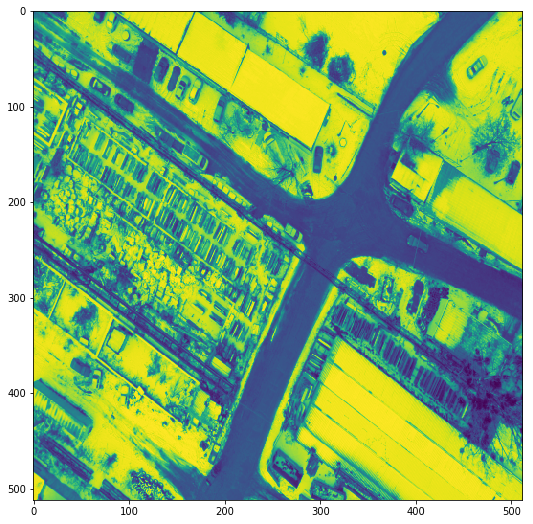

In [10]:
img_batch_index = np.random.randint(0, images.shape[0])

img_c = images[img_batch_index].cpu().detach().numpy()
box = targets[img_batch_index].cpu().detach().numpy()
out_c = out[0].cpu().detach().numpy()

print(img_c.shape, box.shape)

img_c = np.moveaxis(img_c, 0, -1)
box[:, :-1] = box[:, :-1] * img_dim

plt.imshow(img_c[:, :, 0])

In [11]:
box = pd.DataFrame(box)
box.columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf']

box['x'] = box.apply(lambda x: x['xmax'] - x['xmin'], axis=1)
box['y'] = box.apply(lambda x: x['ymax'] - x['ymin'], axis=1)
box

xmin        ymin        xmax        ymax  conf          x          y
0   248.888885  458.370361  283.111115  500.444458   6.0  34.222229  42.074097
1   362.666656  276.740753  378.000000  306.074066   6.0  15.333344  29.333313
2    81.888885   35.111111  102.333336   56.592594   1.0  20.444450  21.481483
3   124.444443   47.703705  141.777771   75.555557   1.0  17.333328  27.851852
4    84.666664   87.555557  107.111115  110.222221   1.0  22.444450  22.666664
5   126.777779  121.777779  148.000000  144.888885   1.0  21.222221  23.111107
6   155.111115  140.148148  183.888885  169.481476   1.0  28.777771  29.333328
7   147.666672   68.148148  164.555557   95.555557   1.0  16.888885  27.407410
8   187.444443   89.777779  203.222229  119.111115   1.0  15.777786  29.333336
9   291.444458  141.185181  304.333344  171.703705   1.0  12.888885  30.518524
10  240.222229  125.481483  265.000000  171.703705   1.0  24.777771  46.222221
11  375.333344  194.814819  397.777771  217.925919   1.0  22.444427  23.111099
12  390.222229  234.074081  413.888885  256.740753   1.0  23.666656  22.666672
13  493.000000  156.444443  510.000000  182.666672   1.0  17.000000  26.222229
14  471.777771  141.185181  491.111115  171.111115   1.0  19.333344  29.925934
15  452.111115   46.666668  474.888885   72.444443   1.0  22.777771  25.777775
16   61.000000  373.777771   72.000000  398.518524   1.0  11.000000  24.740753
17   38.555557  363.259247   60.555557  383.851837   1.0  22.000000  20.592590
18  261.888885  222.518524  282.777771  244.148148   1.0  20.888885  21.629623
19   89.000000  391.111115  102.000000  416.888885   1.0  13.000000  25.777771
20  161.777771   68.740738  178.777771   99.111115   1.0  17.000000  30.370377
21   58.222221   68.740738   81.111115   91.851852   1.0  22.888893  23.111115

Show: 13


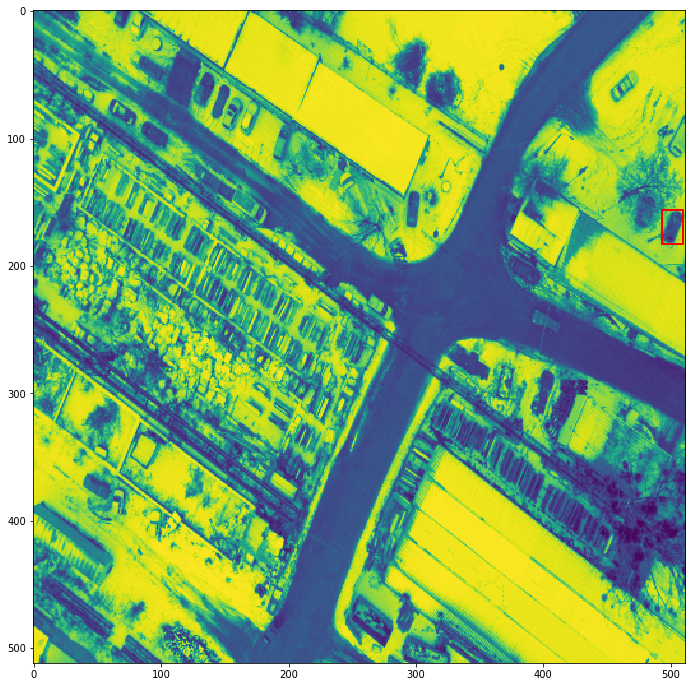

In [12]:
random_box_index = np.random.randint(0, box.shape[0])
print('Show: {}'.format(random_box_index))

show_bbs(img_c[:, :, 0], box.iloc[random_box_index, :])

In [13]:
asd

NameError: name 'asd' is not defined

### processing debug:

In [ ]:
df_annots = pd.read_csv(TRAIN_LABELS)
df_annots = __clean_slashes_df(df_annots)
unique_filenames = df_annots.filename.unique()
basedir = BASEDIR

index = 0

df_filename = df_annots[
    df_annots['filename'] == unique_filenames[index]]

target = df_filename.apply(
    lambda x: np.asarray(
        [x['xmin'], x['ymin'], x['xmax'], x['ymax'], x['class']]), axis=1)
target = np.stack(
    target.values, axis=0).astype(np.float32)

filename_full = basedir + unique_filenames[index]
img = cv2.imread(filename_full, 1)

img_, t_ = preproc(img_dim, rgb_means, p)(img, target)

In [ ]:
img_.shape

In [ ]:
imgn = img_.cpu().detach().numpy()
# imgn = np.swapaxes(imgn, 0, -1)

In [ ]:
plt.imshow(imgn[0, :, :])

In [ ]:
targets